**Created csv with amplitude and time**

In [3]:
import pandas as pd

# Define the path to your raw BCG file
input_path = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\ECG-from-BCG\dataset\data\01\BCG\01_20231105_BCG.csv"
output_path = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\Raw_BCG_AMP&Time.csv"

# Read the CSV file, skipping the first row to get just the amplitude values
with open(input_path, 'r') as f:
    lines = f.readlines()

# Extract header and fs
header = lines[0].strip().split(',')
first_line = lines[1].strip().split(',')
fs = int(first_line[2]) if len(first_line) > 2 else 140
start_timestamp = int(first_line[1]) / 1000  # convert from ms to seconds

# Extract BCG values
bcg_values = []
for line in lines[1:]:
    parts = line.strip().split(',')
    if parts[0].lstrip('-').isdigit():
        bcg_values.append(int(parts[0]))

# Generate time vector based on fs
time_vector = [start_timestamp + i / fs for i in range(len(bcg_values))]

# Create DataFrame
df = pd.DataFrame({
    'Time (s)': time_vector,
    'BCG Amplitude': bcg_values
})

# Save to new CSV
df.to_csv(output_path, index=False)

print(f"Processed CSV saved to: {output_path}")


Processed CSV saved to: C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\Raw_BCG_AMP&Time.csv


**Resampling + main of doctor**

In [4]:
# Import required libraries
import math
import os

import numpy as np
import pandas as pd
from scipy.signal import savgol_filter, resample

from band_pass_filtering import band_pass_filtering
from compute_vitals import vitals
from detect_apnea_events import apnea_events
from detect_body_movements import detect_patterns
from modwt_matlab_fft import modwt
from modwt_mra_matlab_fft import modwtmra
from remove_nonLinear_trend import remove_nonLinear_trend
from data_subplot import data_subplot

# ======================================================================================================================
# Main program starts here
print('\nStart processing ...')

# Path to input CSV (140 Hz sampled data)
input_path = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\Raw_BCG_AMP&Time.csv"
output_path = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\Raw_BCG_Resampled_to_50_Hz.csv"

# Sampling rates
original_fs = 140
target_fs = 50

# Load original CSV file
df = pd.read_csv(input_path)

# Extract data
time = df["Time (s)"].values
amplitude = df["BCG Amplitude"].values

# Duration and number of target samples
duration = time[-1] - time[0]
n_target = int(duration * target_fs)

# Resample amplitude
amplitude_resampled = resample(amplitude, n_target)

# Create new time vector
time_resampled = np.linspace(time[0], time[-1], n_target)

# Create new DataFrame and save to CSV
df_resampled = pd.DataFrame({
    "Time (s)": time_resampled,
    "BCG Amplitude": amplitude_resampled
})
df_resampled.to_csv(output_path, index=False)

print(f"\nResampled data saved to: {output_path}")

# ======================================================================================================================
# Load the resampled data for processing
rawData = df_resampled.values
utc_time = rawData[:, 0]
data_stream = rawData[:, 1]

start_point, end_point, window_shift, fs = 0, 500, 500, target_fs  # now fs = 50
# ==========================================================================================================
data_stream, utc_time = detect_patterns(start_point, end_point, window_shift, data_stream, utc_time, plot=1)
# ==========================================================================================================
# BCG signal extraction
movement = band_pass_filtering(data_stream, fs, "bcg")
# ==========================================================================================================
# Respiratory signal extraction
breathing = band_pass_filtering(data_stream, fs, "breath")
breathing = remove_nonLinear_trend(breathing, 3)
breathing = savgol_filter(breathing, 11, 3)
# ==========================================================================================================
w = modwt(movement, 'bior3.9', 4)
dc = modwtmra(w, 'bior3.9')
wavelet_cycle = dc[4]
# ==========================================================================================================
# Vital Signs estimation - (10 seconds window is an optimal size for vital signs measurement)
t1, t2, window_length, window_shift = 0, 500, 500, 500
hop_size = math.floor((window_length - 1) / 2)
limit = int(math.floor(breathing.size / window_shift))
# ==========================================================================================================
# Heart Rate
beats = vitals(t1, t2, window_shift, limit, wavelet_cycle, utc_time, mpd=1, plot=0)
print('\nHeart Rate Information')
print('Minimum pulse : ', np.around(np.min(beats)))
print('Maximum pulse : ', np.around(np.max(beats)))
print('Average pulse : ', np.around(np.mean(beats)))
# Breathing Rate
beats = vitals(t1, t2, window_shift, limit, breathing, utc_time, mpd=1, plot=0)
print('\nRespiratory Rate Information')
print('Minimum breathing : ', np.around(np.min(beats)))
print('Maximum breathing : ', np.around(np.max(beats)))
print('Average breathing : ', np.around(np.mean(beats)))
# ==============================================================================================================
thresh = 0.3
events = apnea_events(breathing, utc_time, thresh=thresh)
# ==============================================================================================================
# Plot Vitals Example
t1, t2 = 2500, 2500 * 2
data_subplot(data_stream, movement, breathing, wavelet_cycle, t1, t2)
# ==================================================================================================================
print('\nEnd processing ...')



Start processing ...

Resampled data saved to: C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\Raw_BCG_Resampled_to_50_Hz.csv

Heart Rate Information
Minimum pulse :  42253.0
Maximum pulse :  79316.0
Average pulse :  59230.0

Respiratory Rate Information
Minimum breathing :  0.0
Maximum breathing :  29412.0
Average breathing :  13513.0

Apnea Information
start time :  ['07.30.01']  stop time :  ['07.30.01']

Apnea Information
start time :  ['07.30.01', '07.30.01']  stop time :  ['07.30.01', '07.30.01']

Apnea Information
start time :  ['07.30.01', '07.30.01', '07.30.01']  stop time :  ['07.30.01', '07.30.01', '07.30.01']

Apnea Information
start time :  ['07.30.01', '07.30.01', '07.30.01', '07.30.01']  stop time :  ['07.30.01', '07.30.01', '07.30.01', '07.30.01']

Apnea Information
start time :  ['07.30.01', '07.30.01', '07.30.01', '07.30.01', '07.30.01']  stop time :  ['07.30.01', '07.30.01', '07.30.01', '07.30.01', '07.30.01']

Apnea Information
start time :

**plot resampled data**

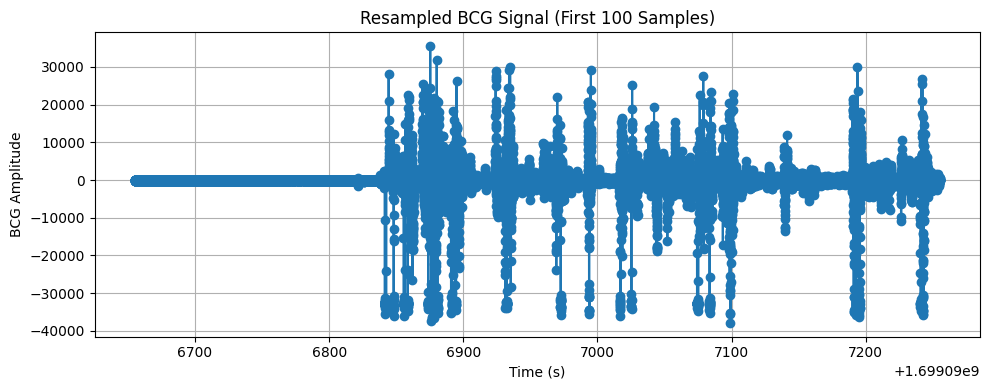

In [9]:
# Add this at the beginning of your cell to enable inline plotting
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

# Path to resampled CSV
resampled_csv_path = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\Raw_BCG_Resampled_to_50_Hz.csv"

# Load the data
df = pd.read_csv(resampled_csv_path)

# Extract the first 1000 rows
df_plot = df.head(30000)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(df_plot["Time (s)"], df_plot["BCG Amplitude"], marker='o', linestyle='-')
plt.title("Resampled BCG Signal (First 100 Samples)")
plt.xlabel("Time (s)")
plt.ylabel("BCG Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()


**syncronization**

In [10]:
import pandas as pd

# 1) Paths: adjust to your actual files
input_csv  = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\Raw_BCG_Resampled_to_50_Hz.csv"
output_csv = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\Raw_BCG_Resampled_to_50_Hz_with_readable_datetime.csv"

# 2) Load
df = pd.read_csv(input_csv)

# 3) Convert Unix‐time to datetime strings
#    If "Time (s)" is a float, we floor or round as you prefer;
#    here we just interpret the integer part as whole seconds.
df['DateTime'] = pd.to_datetime(df['Time (s)'], unit='s') \
                   .dt.strftime('%Y/%m/%d %H:%M:%S')

# 4) (Optional) If you want to replace the original column:
#    df.drop(columns=['Time (s)'], inplace=True)
#    df.rename(columns={'DateTime':'Time (s)'}, inplace=True)

# 5) Save out
df.drop(columns=['Time (s)'], inplace=True)
df.to_csv(output_csv, index=False)
print(f"Saved converted CSV to: {output_csv}")


Saved converted CSV to: C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\Raw_BCG_Resampled_to_50_Hz_with_readable_datetime.csv


In [12]:
import pandas as pd

# ── 1) Adjust these paths to point at your actual files ─────────────────────────
ecg_csv_in   = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\ECG-from-BCG\dataset\data\01\Reference\RR\01_20231105_RR.csv"
bcg_csv_in   = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\Raw_BCG_Resampled_to_50_Hz_with_readable_datetime.csv"

ecg_csv_out  = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\ecg_synchronized.csv"
bcg_csv_out  = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\bcg_synchronized.csv"

# ── 2) Load both CSVs ───────────────────────────────────────────────────────────
df_ecg = pd.read_csv(ecg_csv_in)
df_bcg = pd.read_csv(bcg_csv_in)

# ── 3) Parse their time columns to pandas datetime ─────────────────────────────
#    (adjust formats if your strings differ)
df_ecg['dt'] = pd.to_datetime(df_ecg['Timestamp'], format='%Y/%m/%d %H:%M:%S')
df_bcg['dt'] = pd.to_datetime(df_bcg['DateTime'], format='%Y/%m/%d %H:%M:%S')

# ── 4) Compute overlapping window ───────────────────────────────────────────────
start_ecg = df_ecg['dt'].min()
end_ecg   = df_ecg['dt'].max()

start_bcg = df_bcg['dt'].min()
end_bcg   = df_bcg['dt'].max()

# the sync window is from the later of the two starts to the earlier of the two ends
sync_start = max(start_ecg, start_bcg)
sync_end   = min(end_ecg,   end_bcg)

print(f"Synchronizing both signals to window:\n  start = {sync_start}\n    end = {sync_end}")

# ── 5) Trim each DataFrame to that window ────────────────────────────────────────
df_ecg_sync = df_ecg[(df_ecg['dt'] >= sync_start) & (df_ecg['dt'] <= sync_end)].copy()
df_bcg_sync = df_bcg[(df_bcg['dt'] >= sync_start) & (df_bcg['dt'] <= sync_end)].copy()

# ── 6) (Optional) drop the helper 'dt' columns or reorder as you like
#    Here we keep the original timestamp columns and drop the parsed 'dt' column:
df_ecg_sync = df_ecg_sync.drop(columns=['dt'])
df_bcg_sync = df_bcg_sync.drop(columns=['dt'])

# ── 7) Save out the synchronized CSVs ───────────────────────────────────────────
df_ecg_sync.to_csv(ecg_csv_out, index=False)
df_bcg_sync.to_csv(bcg_csv_out, index=False)

print("Saved synchronized ECG to:", ecg_csv_out)
print("Saved synchronized BCG to:", bcg_csv_out)


Synchronizing both signals to window:
  start = 2023-11-04 19:12:20
    end = 2023-11-04 22:05:51
Saved synchronized ECG to: C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\ecg_synchronized.csv
Saved synchronized BCG to: C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\bcg_synchronized.csv


In [ ]:
import pandas as pd

# Load the CSV
bcg_sync = pd.read_csv(r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\bcg_synchronized.csv')

# Convert 'DateTime' to datetime and then to Unix timestamp
bcg_sync['DateTime'] = pd.to_datetime(bcg_sync['DateTime'])
bcg_sync['UnixTime'] = bcg_sync['DateTime'].apply(lambda x: int(x.timestamp()))

# Drop the DateTime column
bcg_sync.drop(columns=['DateTime'], inplace=True)

# Save updated CSV
bcg_sync.to_csv(
    r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\unix_bcg_synchronized.csv',
    index=False
)

print("DateTime column dropped and file saved.")


DateTime column dropped and file saved.


**main code from doctor**

**partitionin main for debugging**

**new detect_patterns**

In [39]:
import math
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def detect_patterns1(pt1, pt2, win_size, data, time, plot=0):
    # Store start and end point
    pt1_, pt2_ = pt1, pt2

    limit = int(math.floor(data.size / win_size))
    flag = np.zeros([data.size, 1])
    event_flags = np.zeros([limit, 1])
    segments_sd = []

    # Compute standard deviation for each window
    for i in range(limit):
        sub_data = data[pt1:pt2]
        segments_sd.append(np.std(sub_data, ddof=1))
        pt1 = pt2
        pt2 += win_size

    # Compute MAD
    mad = np.sum(np.abs(segments_sd - np.mean(segments_sd))) / len(segments_sd)
    thresh1, thresh2 = 15, 2 * mad

    # Reset pt1 and pt2
    pt1, pt2 = pt1_, pt2_

    # Classify each window
    for j in range(limit):
        std_fos = np.around(segments_sd[j])
        if std_fos < thresh1:
            flag[pt1:pt2] = 3  # No movement
            event_flags[j] = 3
        elif std_fos > thresh2:
            flag[pt1:pt2] = 2  # Movement
            event_flags[j] = 2
        else:
            flag[pt1:pt2] = 1  # Sleeping
            event_flags[j] = 1
        pt1 = pt2
        pt2 += win_size

    # Plotting
    if plot == 1:
        data_for_plot = data
        width = np.min(data_for_plot)
        height = np.max(data_for_plot) + abs(width) if width < 0 else np.max(data_for_plot)

        current_axis = plt.gca()
        plt.plot(np.arange(data.size), data_for_plot, '-k', linewidth=1)
        plt.xlabel('Time [Samples]')
        plt.ylabel('Amplitude [mV]')
        plt.gcf().autofmt_xdate()

        for j in range(limit):
            start_idx = j * win_size
            end_idx = start_idx + win_size
            sub_data = data_for_plot[start_idx:end_idx]
            sub_time = np.arange(start_idx, end_idx) / 50.0

            if event_flags[j] == 3:  # No-movement
                plt.plot(sub_time, sub_data, '-k', linewidth=1)
                current_axis.add_patch(Rectangle((start_idx, width), win_size, height, facecolor="#FAF0BE", alpha=.2))
            elif event_flags[j] == 2:  # Movement
                plt.plot(sub_time, sub_data, '-k', linewidth=1)
                current_axis.add_patch(Rectangle((start_idx, width), win_size, height, facecolor="#FF004F", alpha=1.0))
            else:  # Sleeping
                plt.plot(sub_time, sub_data, '-k', linewidth=1)
                current_axis.add_patch(Rectangle((start_idx, width), win_size, height, facecolor="#00FFFF", alpha=.2))

        plt.savefig('./results/rawData.png')

    # Identify indices to remove (movement and no-movement)
    bad_indices = []
    for j in range(limit):
        start_idx = j * win_size
        end_idx = start_idx + win_size
        if event_flags[j] == 2 or event_flags[j] == 3:
            bad_indices.extend(range(start_idx, end_idx))

    bad_indices = np.array(bad_indices)
    valid_indices = bad_indices[(bad_indices >= 0) & (bad_indices < len(time))]  # Ensure safe indexing


    # Mask out the bad indices
    mask = np.ones(len(data), dtype=bool)
    mask[valid_indices] = False
    filtered_data = data[mask]
    filtered_time = time[mask]

    return filtered_data, filtered_time


In [ ]:
# Import required libraries
import math
import os
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter

from band_pass_filtering import band_pass_filtering
from compute_vitals import vitals
from detect_apnea_events import apnea_events
# from detect_body_movements import detect_patterns
from modwt_matlab_fft import modwt
from modwt_mra_matlab_fft import modwtmra
from remove_nonLinear_trend import remove_nonLinear_trend
from data_subplot import data_subplot
# ======================================================================================================================

# Main program starts here
print('\nstart processing ...')

# File path
file = r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\unix_bcg_synchronized.csv'

if file.endswith(".csv"):
    fileName = os.path.join(file)
    
    # Check if the file is not empty
    if os.stat(fileName).st_size != 0:
        
        # Read the data from the file
        rawData = pd.read_csv(fileName, sep=",", header=None, skiprows=1).values
        utc_time = rawData[:, 1]
        data_stream = rawData[:, 0]

        # Define parameters for windowing
        start_point, end_point, window_shift, fs = 0, 100, 100, 50

        # ==========================================================================================================
        # Apply the detect_patterns function
        data_stream_filtered, utc_time_filtered, removed = detect_patterns1(
            start_point, end_point, window_shift, data_stream, utc_time, plot=0
        )

        # Create a DataFrame to save the filtered results
        filtered_data = pd.DataFrame({
            'UTC_Time': utc_time_filtered,
            'Data_Stream': data_stream_filtered
        })

        # Save the filtered data to a new CSV file
        output_file = r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\100_samples_bcg.csv'
        filtered_data.to_csv(output_file, index=False)

        np.set_printoptions(threshold=np.inf)
        print('filtered times', removed)



start processing ...
filtered times [1.69912582e+09 1.69912582e+09 1.69912582e+09 1.69912582e+09
 1.69912582e+09 1.69912582e+09 1.69912582e+09 1.69912582e+09
 1.69912582e+09 1.69912582e+09 1.69912582e+09 1.69912582e+09
 1.69912582e+09 1.69912582e+09 1.69912582e+09 1.69912582e+09
 1.69912582e+09 1.69912582e+09 1.69912582e+09 1.69912582e+09
 1.69912582e+09 1.69912582e+09 1.69912582e+09 1.69912582e+09
 1.69912582e+09 1.69912582e+09 1.69912582e+09 1.69912582e+09
 1.69912582e+09 1.69912582e+09 1.69912582e+09 1.69912582e+09
 1.69912582e+09 1.69912582e+09 1.69912582e+09 1.69912582e+09
 1.69912582e+09 1.69912582e+09 1.69912582e+09 1.69912582e+09
 1.69912582e+09 1.69912582e+09 1.69912582e+09 1.69912582e+09
 1.69912582e+09 1.69912582e+09 1.69912582e+09 1.69912582e+09
 1.69912582e+09 1.69912582e+09 1.69912582e+09 1.69912582e+09
 1.69912582e+09 1.69912582e+09 1.69912582e+09 1.69912582e+09
 1.69912582e+09 1.69912582e+09 1.69912582e+09 1.69912582e+09
 1.69912582e+09 1.69912582e+09 1.69912582e+09 1.

In [18]:
import pandas as pd

# Load the CSV file
file_path = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\unix_bcg_synchronized.csv"
df = pd.read_csv(file_path)

# Round the first column to 1 decimal place
df['BCG Amplitude'] = df['BCG Amplitude'].round(1)

# Save with float format to enforce 1 decimal place in output
output_file_path = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\rounded_unix_bcg_synchronized.csv"
df.to_csv(output_file_path, index=False, header=False, float_format='%.1f')


In [20]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

file = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\rounded_unix_bcg_synchronized.csv"

rawData = pd.read_csv(file, sep=",", header=None).values
utc_time = rawData[:, 1]
data_stream = rawData[:, 0]
print(data_stream[1000:1010])

[ -34.2  -32.8  -93.5 -753.2 -719.8 -722.2 -756.  -520.2 -602.  -104.5]


**ploting the whole unix_BCG_synchronized + debugg after each change**

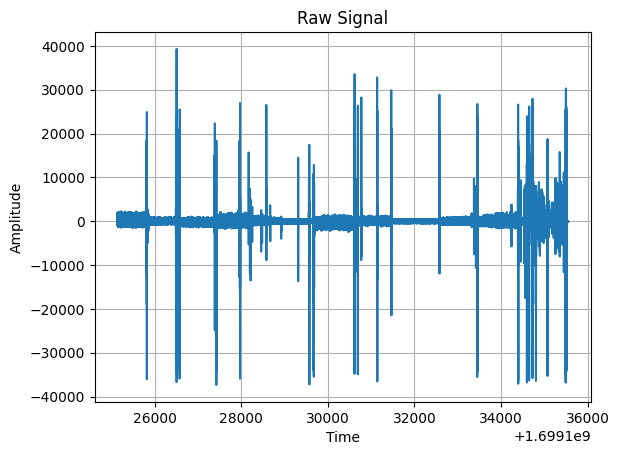

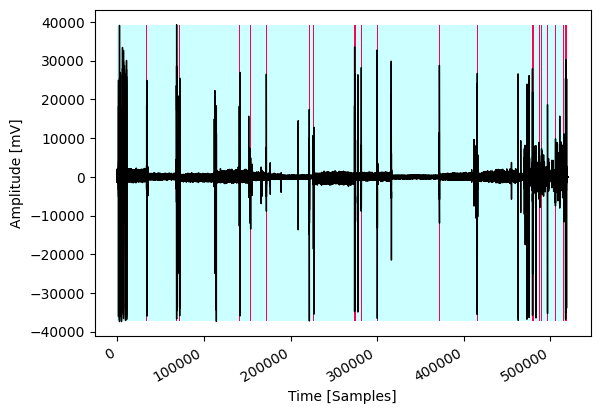

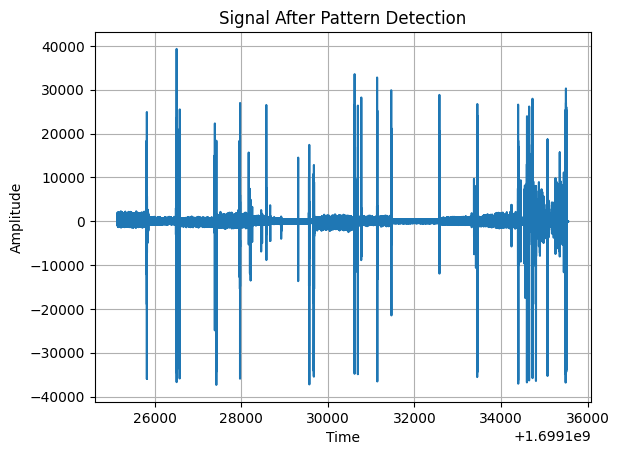

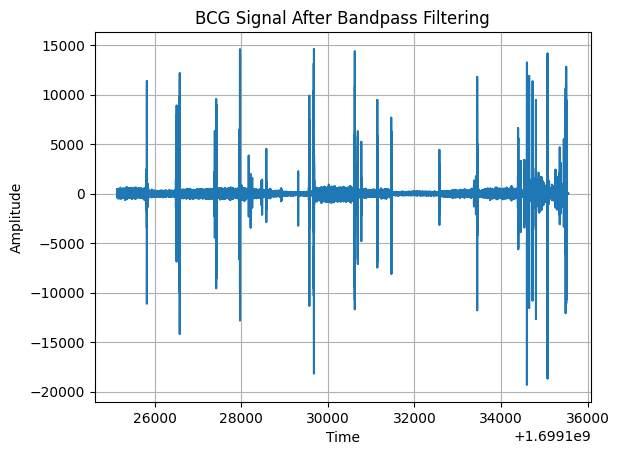

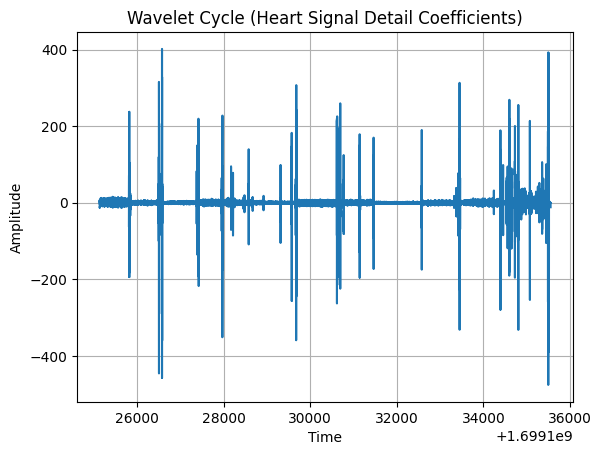


Heart Rate Information
Minimum pulse :  60000.0
Maximum pulse :  102000.0
Average pulse :  81337.0


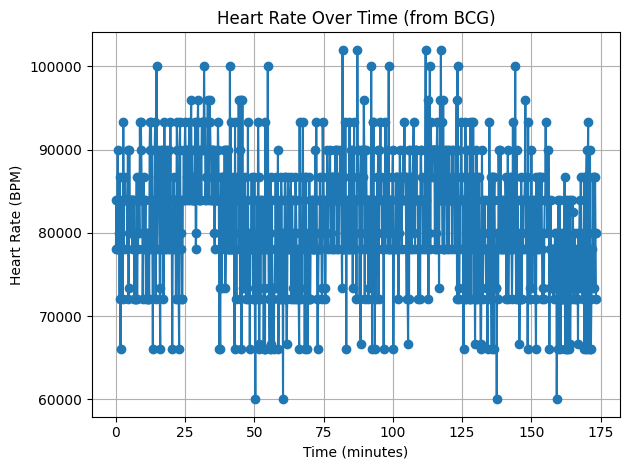


Respiratory Rate Information
Minimum breathing :  0.0
Maximum breathing :  30000.0
Average breathing :  16974.0

Apnea Information
start time :  ['07.30.01']  stop time :  ['07.30.01']

Apnea Information
start time :  ['07.30.01', '07.30.01']  stop time :  ['07.30.01', '07.30.01']

Apnea Information
start time :  ['07.30.01', '07.30.01', '07.30.01']  stop time :  ['07.30.01', '07.30.01', '07.30.01']

Apnea Information
start time :  ['07.30.01', '07.30.01', '07.30.01', '07.30.01']  stop time :  ['07.30.01', '07.30.01', '07.30.01', '07.30.01']

Apnea Information
start time :  ['07.30.01', '07.30.01', '07.30.01', '07.30.01', '07.30.01']  stop time :  ['07.30.01', '07.30.01', '07.30.01', '07.30.01', '07.30.01']

Apnea Information
start time :  ['07.30.01', '07.30.01', '07.30.01', '07.30.01', '07.30.01', '07.30.01']  stop time :  ['07.30.01', '07.30.01', '07.30.01', '07.30.01', '07.30.01', '07.30.01']

Apnea Information
start time :  ['07.30.01', '07.30.01', '07.30.01', '07.30.01', '07.30.

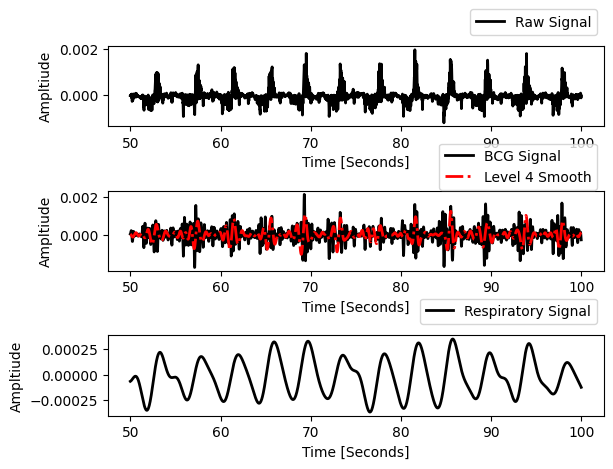

In [30]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

file = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\rounded_unix_bcg_synchronized.csv"

if file.endswith(".csv"):
    fileName = os.path.join(file)
    if os.stat(fileName).st_size != 0:
        rawData = pd.read_csv(fileName, sep=",", header=None, skiprows=1).values
        utc_time = rawData[:, 1]
        data_stream = rawData[:, 0]
        # Plot raw signal
        plt.figure()
        plt.plot(utc_time, data_stream)
        plt.title("Raw Signal")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.show()

        start_point, end_point, window_shift, fs = 0, 500, 500, 50

        # ==========================================================================================================
        data_stream, utc_time = detect_patterns(start_point, end_point, window_shift, data_stream, utc_time, plot=1)

        # Plot after pattern detection
        plt.figure()
        plt.plot(utc_time, data_stream)
        plt.title("Signal After Pattern Detection")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.show()

        # ==========================================================================================================
        # BCG signal extraction
        movement = band_pass_filtering(data_stream, fs, "bcg")

        # Plot BCG signal
        plt.figure()
        plt.plot(utc_time, movement)
        plt.title("BCG Signal After Bandpass Filtering")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.show()

        # ==========================================================================================================
        # Respiratory signal extraction
        breathing = band_pass_filtering(data_stream, fs, "breath")
        breathing = remove_nonLinear_trend(breathing, 3)
        breathing = savgol_filter(breathing, 11, 3)
        # ==========================================================================================================
        # Wavelet transform
        w = modwt(movement, 'bior3.9', 4)
        dc = modwtmra(w, 'bior3.9')
        wavelet_cycle = dc[4]

        # Plot wavelet cycle (heart activity)
        plt.figure()
        plt.plot(utc_time, wavelet_cycle)
        plt.title("Wavelet Cycle (Heart Signal Detail Coefficients)")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.show()

        # ==========================================================================================================
        # Vital Signs estimation - (10 seconds window is an optimal size for vital signs measurement)
        t1, t2, window_length, window_shift = 0, 500, 500, 500
        hop_size = math.floor((window_length - 1) / 2)
        limit = int(math.floor(breathing.size / window_shift))

        # Heart Rate
        beats = vitals(t1, t2, window_shift, limit, wavelet_cycle, utc_time, mpd=1, plot=0)
        print('\nHeart Rate Information')
        print('Minimum pulse : ', np.around(np.min(beats)))
        print('Maximum pulse : ', np.around(np.max(beats)))
        print('Average pulse : ', np.around(np.mean(beats)))

        # Plot heart rate over windows
        plt.figure()
        time_axis = np.arange(len(beats)) * (window_shift / fs) / 60  # in minutes
        plt.plot(time_axis, beats, marker='o', linestyle='-')
        plt.title('Heart Rate Over Time (from BCG)')
        plt.xlabel('Time (minutes)')
        plt.ylabel('Heart Rate (BPM)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # ==========================================================================================================
        # Breathing Rate (optional)
        beats = vitals(t1, t2, window_shift, limit, breathing, utc_time, mpd=1, plot=0)
        print('\nRespiratory Rate Information')
        print('Minimum breathing : ', np.around(np.min(beats)))
        print('Maximum breathing : ', np.around(np.max(beats)))
        print('Average breathing : ', np.around(np.mean(beats)))

        # ==========================================================================================================
        # Apnea Detection
        thresh = 0.3
        events = apnea_events(breathing, utc_time, thresh=thresh)

        # ==========================================================================================================
        # Plot Combined Vitals Example
        t1, t2 = 2500, 2500 * 2
        data_subplot(data_stream, movement, breathing, wavelet_cycle, t1, t2)

        print('\nEnd processing ...')


**final code that plot bland_altman and boxplot**

In [ ]:
import math
import os
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from band_pass_filtering import band_pass_filtering
from compute_vitals import vitals
from detect_apnea_events import apnea_events
from detect_body_movements import detect_patterns
from modwt_matlab_fft import modwt
from modwt_mra_matlab_fft import modwtmra
from remove_nonLinear_trend import remove_nonLinear_trend
from data_subplot import data_subplot
from beat_to_beat import compute_rate

# Main program starts here
print('\nstart processing ...')

# Define sampling frequency
target_fs = 50  # Hz, as the data is already resampled to 50 Hz

# Load BCG and ECG data
bcg_file = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\rounded_unix_bcg_synchronized.csv"
ecg_file_path = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\ecg_synchronized.csv"

# Load BCG data
bcg_data = pd.read_csv(bcg_file, sep=",", header=None, skiprows=1).values
bcg_data_stream = bcg_data[:, 0].astype(float)  # First column is the signal data (amplitude)
bcg_timestamps = bcg_data[:, 1].astype(np.int64) * 1000  # Convert seconds to milliseconds

# Debug: Print a few BCG timestamps to verify format
print("Sample BCG timestamps (Unix ms):", bcg_timestamps[:5])
print("Sample BCG signal data:", bcg_data_stream[:5])

# Load ECG data (assuming format: Timestamp, Heart Rate, RR Interval in seconds)
ecg_data = pd.read_csv(ecg_file_path, sep=",", header=None, skiprows=1).values
ecg_timestamps_str = ecg_data[:, 0]  # Timestamps as strings
ecg_hr = ecg_data[:, 1].astype(float)  # Heart Rate (reference HR)
ecg_rr = ecg_data[:, 2].astype(float)  # RR Interval in seconds

# Convert ECG timestamps to Unix timestamps (milliseconds)
try:
    ecg_timestamps = pd.to_datetime(ecg_timestamps_str, format='ISO8601').astype('int64') // 10**6  # Convert to ms
except ValueError as e:
    print("Error parsing ECG timestamps:", e)
    print("Please verify the timestamp format in the ECG data.")
    raise

# Debug: Print converted timestamps
print("Sample ECG timestamps (converted to Unix ms):", ecg_timestamps[:5])

# Detect patterns and remove segments from both BCG and ECG
start_point, end_point, window_shift = 0, 500, 500
filtered_bcg, filtered_bcg_time = detect_patterns(start_point, end_point, window_shift, bcg_data_stream, bcg_timestamps, plot=1)

# Map filtered BCG indices to ECG indices
# Assuming ECG is at ~1 Hz and BCG is at 50 Hz, use 50 as the scaling factor
filtered_indices = np.where(np.in1d(bcg_timestamps, filtered_bcg_time))[0]
ecg_indices = np.floor(filtered_indices / (target_fs / 1)).astype(int)  # Scale by 50
ecg_indices = np.unique(ecg_indices)
filtered_ecg_hr = ecg_hr[ecg_indices]
filtered_ecg_timestamps = ecg_timestamps[ecg_indices]

# BCG signal extraction
movement = band_pass_filtering(filtered_bcg, target_fs, "bcg")

# Respiratory signal extraction
breathing = band_pass_filtering(filtered_bcg, target_fs, "breath")
breathing = remove_nonLinear_trend(breathing, 3)
breathing = savgol_filter(breathing, 11, 3)

# Wavelet transform for BCG signal
w = modwt(movement, 'bior3.9', 4)
dc = modwtmra(w, 'bior3.9')
wavelet_cycle = dc[4]

# Vital Signs estimation (10 seconds window)
t1, t2, window_length, window_shift = 0, 500, 500, 500
hop_size = math.floor((window_length - 1) / 2)
limit = int(math.floor(breathing.size / window_shift))

# Compute Heart Rate from BCG (using J-peaks)
beats = vitals(t1, t2, window_shift, limit, wavelet_cycle, filtered_bcg_time, mpd=15, plot=0)
print('\nHeart Rate Information (BCG)')
print('Minimum pulse : ', np.around(np.min(beats)))
print('Maximum pulse : ', np.around(np.max(beats)))
print('Average pulse : ', np.around(np.mean(beats)))

# Breathing Rate with adjusted mpd
breaths = vitals(t1, t2, window_shift, limit, breathing, filtered_bcg_time, mpd=75, plot=0)
print('\nRespiratory Rate Information')
print('Minimum breathing : ', np.around(np.min(breaths)))
print('Maximum breathing : ', np.around(np.max(breaths)))
print('Average breathing : ', np.around(np.mean(breaths)))

# Apnea Events Detection
thresh = 0.3
events = apnea_events(breathing, filtered_bcg_time, thresh=thresh)

# Plot Vitals Example
t1, t2 = 2500, 2500 * 2
data_subplot(filtered_bcg, movement, breathing, wavelet_cycle, t1, t2)

# Compare BCG-derived HR with ECG-derived HR
min_length = min(len(beats), len(filtered_ecg_hr))
bcg_hr = beats[:min_length]
ecg_hr_ref = filtered_ecg_hr[:min_length]

# Compute error metrics
mae = np.mean(np.abs(bcg_hr - ecg_hr_ref))
rmse = np.sqrt(np.mean((bcg_hr - ecg_hr_ref) ** 2))
mape = np.mean(np.abs((bcg_hr - ecg_hr_ref) / ecg_hr_ref)) * 100

print('\nHeart Rate Comparison Metrics')
print('Mean Absolute Error (MAE): ', np.around(mae, 2))
print('Root Mean Square Error (RMSE): ', np.around(rmse, 2))
print('Mean Absolute Percentage Error (MAPE): ', np.around(mape, 2), '%')

# Bland-Altman Plot
mean_hr = (bcg_hr + ecg_hr_ref) / 2
diff_hr = bcg_hr - ecg_hr_ref
mean_diff = np.mean(diff_hr)
std_diff = np.std(diff_hr)
plt.figure(figsize=(8, 6))
plt.scatter(mean_hr, diff_hr, c='blue', alpha=0.5)
plt.axhline(mean_diff, color='red', linestyle='--')
plt.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--')
plt.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--')
plt.xlabel('Mean Heart Rate (BPM)')
plt.ylabel('Difference (BCG HR - ECG HR) (BPM)')
plt.title('Bland-Altman Plot')
plt.savefig(r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\code\results\bland_altman.png')
plt.close()

# Pearson Correlation Plot
plt.figure(figsize=(8, 6))
plt.scatter(ecg_hr_ref, bcg_hr, c='blue', alpha=0.5)
plt.plot([min(ecg_hr_ref), max(ecg_hr_ref)], [min(ecg_hr_ref), max(ecg_hr_ref)], 'r--')
plt.xlabel('ECG Heart Rate (BPM)')
plt.ylabel('BCG Heart Rate (BPM)')
plt.title('Pearson Correlation Plot')
corr, _ = pearsonr(ecg_hr_ref, bcg_hr)
plt.text(min(ecg_hr_ref), max(bcg_hr), f'Correlation: {corr:.2f}')
plt.savefig(r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\code\results\pearson_correlation.png')
plt.close()

# Boxplot
plt.figure(figsize=(8, 6))
plt.boxplot([ecg_hr_ref, bcg_hr], labels=['ECG HR', 'BCG HR'])
plt.ylabel('Heart Rate (BPM)')
plt.title('Boxplot of ECG vs BCG Heart Rate')
plt.savefig(r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\code\results\boxplot.png')
plt.close()

print('\nEnd processing ...')


start processing ...
Sample BCG timestamps (Unix ms): [1699125141000 1699125141000 1699125141000 1699125141000 1699125141000]
Sample BCG signal data: [143.1 -74.1 -45.5  92.3 -15.1]
Sample ECG timestamps (converted to Unix ms): Index([1699125164000, 1699125164000, 1699125165000, 1699125166000,
       1699125166000],
      dtype='int64')

Heart Rate Information (BCG)
Minimum pulse :  54.0
Maximum pulse :  107.0
Average pulse :  80.0

Respiratory Rate Information
Minimum breathing :  15.0
Maximum breathing :  38.0
Average breathing :  27.0

Apnea Information
start time :  ['07.58.19']  stop time :  ['07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19', '07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19']

Apnea Information


**modified code**

In [8]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.interpolate import interp1d

# Import functions (assumed to be available in your environment)
from band_pass_filtering import band_pass_filtering
from compute_vitals import vitals
from detect_apnea_events import apnea_events
from detect_body_movements import detect_patterns
from modwt_matlab_fft import modwt
from modwt_mra_matlab_fft import modwtmra
from remove_nonLinear_trend import remove_nonLinear_trend

# Load BCG data
bcg_file = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\rounded_unix_bcg_synchronized.csv"
bcg_data = pd.read_csv(bcg_file, sep=",", header=None, skiprows=1).values
bcg_data_stream = bcg_data[:, 0].astype(np.float32)  # Use float32 to reduce memory usage
bcg_timestamps = bcg_data[:, 1].astype(np.int64) * 1000  # Convert seconds to milliseconds

# Fix identical timestamps (50 Hz = 20 ms/sample)
if np.all(bcg_timestamps == bcg_timestamps[0]):
    bcg_timestamps = np.arange(bcg_timestamps[0], bcg_timestamps[0] + len(bcg_data_stream) * 20, 20)

# Load ECG data
ecg_file = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\ecg_synchronized.csv"
ecg_data = pd.read_csv(ecg_file, sep=",", header=None, skiprows=1).values
ecg_timestamps = pd.to_datetime(ecg_data[:, 0]).astype('int64') // 10**6  # Timestamps in ms
ecg_hr = ecg_data[:, 1].astype(np.float32)  # Use float32 to reduce memory usage

# Signal processing
target_fs = 50  # Hz
# Disable plotting in detect_patterns to improve performance
filtered_bcg, filtered_bcg_time = detect_patterns(0, 500, 500, bcg_data_stream, bcg_timestamps, plot=0)
movement = band_pass_filtering(filtered_bcg, target_fs, "bcg")
breathing = band_pass_filtering(filtered_bcg, target_fs, "breath")
breathing = remove_nonLinear_trend(breathing, 3)
breathing = savgol_filter(breathing, 11, 3)
w = modwt(movement, 'bior3.9', 4)
dc = modwtmra(w, 'bior3.9')
wavelet_cycle = dc[4]

# Compute vitals
limit = int(np.floor(breathing.size / 500))
beats = vitals(0, 500, 500, limit, wavelet_cycle, filtered_bcg_time, mpd=20, plot=0)
breaths = vitals(0, 500, 500, limit, breathing, filtered_bcg_time, mpd=75, plot=0)
events = apnea_events(breathing, filtered_bcg_time, thresh=0.3)

# Output results
print("Heart Rate (BCG): Min:", np.min(beats), "Max:", np.max(beats), "Avg:", np.mean(beats))
print("Respiratory Rate: Min:", np.min(breaths), "Max:", np.max(breaths), "Avg:", np.mean(breaths))
print("Apnea Events:", events)

# Generate time array for heart rate (center of each 500-sample window)
hr_time = filtered_bcg_time[250::500][:len(beats)]

# Compare with ECG using interpolation
ecg_interp = interp1d(ecg_timestamps, ecg_hr, kind='linear', bounds_error=False, fill_value='extrapolate')
ecg_hr_at_hr_time = ecg_interp(hr_time)
rmse = np.sqrt(np.mean((beats - ecg_hr_at_hr_time) ** 2))
mape = np.mean(np.abs((beats - ecg_hr_at_hr_time) / ecg_hr_at_hr_time)) * 100
print("RMSE:", rmse, "MAPE:", mape, "%")

# Plot heart rate over time
plt.plot(hr_time / 60000, beats, 'b-', label='BCG HR')
plt.xlabel("Time (minutes)")
plt.ylabel("Heart Rate (BPM)")
plt.ylim(0, 150)
plt.legend()
plt.savefig("corrected_hr_plot.png")
plt.close()


Apnea Information
start time :  ['07.58.19']  stop time :  ['07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19', '07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19

**modified code that give correlation plot**

In [19]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.interpolate import interp1d

# Import functions (assumed to be available in your environment)
from band_pass_filtering import band_pass_filtering
from compute_vitals import vitals
from detect_apnea_events import apnea_events
from detect_body_movements import detect_patterns
from modwt_matlab_fft import modwt
from modwt_mra_matlab_fft import modwtmra
from remove_nonLinear_trend import remove_nonLinear_trend

# Load BCG data
bcg_file = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\rounded_unix_bcg_synchronized.csv"
bcg_data = pd.read_csv(bcg_file, sep=",", header=None, skiprows=1).values
bcg_data_stream = bcg_data[:, 0].astype(np.float32)  # Use float32 to reduce memory usage
bcg_timestamps = bcg_data[:, 1].astype(np.int64) * 1000  # Convert seconds to milliseconds

# Fix identical timestamps (50 Hz = 20 ms/sample)
if np.all(bcg_timestamps == bcg_timestamps[0]):
    bcg_timestamps = np.arange(bcg_timestamps[0], bcg_timestamps[0] + len(bcg_data_stream) * 20, 20)

# Load ECG data
ecg_file = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\ecg_synchronized.csv"
ecg_data = pd.read_csv(ecg_file, sep=",", header=None, skiprows=1).values
ecg_timestamps = pd.to_datetime(ecg_data[:, 0]).astype('int64') // 10**6  # Timestamps in ms
ecg_hr = ecg_data[:, 1].astype(np.float32)  # Use float32 to reduce memory usage

# Signal processing
target_fs = 50  # Hz
# Disable plotting in detect_patterns to improve performance
filtered_bcg, filtered_bcg_time = detect_patterns(0, 500, 500, bcg_data_stream, bcg_timestamps, plot=0)
movement = band_pass_filtering(filtered_bcg, target_fs, "bcg")
breathing = band_pass_filtering(filtered_bcg, target_fs, "breath")
breathing = remove_nonLinear_trend(breathing, 3)
breathing = savgol_filter(breathing, 11, 3)
w = modwt(movement, 'bior3.9', 4)
dc = modwtmra(w, 'bior3.9')
wavelet_cycle = dc[4]

# Compute vitals
limit = int(np.floor(breathing.size / 500))
beats = vitals(0, 500, 500, limit, wavelet_cycle, filtered_bcg_time, mpd=20, plot=0)
breaths = vitals(0, 500, 500, limit, breathing, filtered_bcg_time, mpd=75, plot=0)
events = apnea_events(breathing, filtered_bcg_time, thresh=0.3)

# Output results
print("Heart Rate (BCG): Min:", np.min(beats), "Max:", np.max(beats), "Avg:", np.mean(beats))
print("Respiratory Rate: Min:", np.min(breaths), "Max:", np.max(breaths), "Avg:", np.mean(breaths))
print("Apnea Events:", events)

# Generate time array for heart rate (center of each 500-sample window)
hr_time = filtered_bcg_time[250::500][:len(beats)]

# Compare with ECG using interpolation
ecg_interp = interp1d(ecg_timestamps, ecg_hr, kind='linear', bounds_error=False, fill_value='extrapolate')
ecg_hr_at_hr_time = ecg_interp(hr_time)

# Assign BCG and ECG heart rate arrays for comparison
bcg_hr = beats
ecg_hr_ref = ecg_hr_at_hr_time

# Compute error metrics
mae = np.mean(np.abs(bcg_hr - ecg_hr_ref))
rmse = np.sqrt(np.mean((bcg_hr - ecg_hr_ref) ** 2))
mape = np.mean(np.abs((bcg_hr - ecg_hr_ref) / ecg_hr_ref)) * 100

print('\nHeart Rate Comparison Metrics')
print('Mean Absolute Error (MAE): ', np.around(mae, 2))
print('Root Mean Square Error (RMSE): ', np.around(rmse, 2))
print('Mean Absolute Percentage Error (MAPE): ', np.around(mape, 2), '%')

# Bland-Altman Plot
mean_hr = (bcg_hr + ecg_hr_ref) / 2
diff_hr = bcg_hr - ecg_hr_ref
mean_diff = np.mean(diff_hr)
std_diff = np.std(diff_hr)
plt.figure(figsize=(8, 6))
plt.scatter(mean_hr, diff_hr, c='blue', alpha=0.5)
plt.axhline(mean_diff, color='red', linestyle='--')
plt.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--')
plt.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--')
plt.xlabel('Mean Heart Rate (BPM)')
plt.ylabel('Difference (BCG HR - ECG HR) (BPM)')
plt.title('Bland-Altman Plot')
plt.savefig(r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\code\results\bland_altman.png')
plt.close()

# Pearson Correlation Plot
plt.figure(figsize=(8, 6))
plt.scatter(ecg_hr_ref, bcg_hr, c='blue', alpha=0.5)
plt.plot([min(ecg_hr_ref), max(ecg_hr_ref)], [min(ecg_hr_ref), max(ecg_hr_ref)], 'r--')
plt.xlabel('ECG Heart Rate (BPM)')
plt.ylabel('BCG Heart Rate (BPM)')
plt.title('Pearson Correlation Plot')
corr, _ = pearsonr(ecg_hr_ref, bcg_hr)
plt.text(min(ecg_hr_ref), max(bcg_hr), f'Correlation: {corr:.2f}')
plt.savefig(r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\code\results\pearson_correlation.png')
plt.close()

# Boxplot
plt.figure(figsize=(8, 6))
plt.boxplot([ecg_hr_ref, bcg_hr], labels=['ECG HR', 'BCG HR'])
plt.ylabel('Heart Rate (BPM)')
plt.title('Boxplot of ECG vs BCG Heart Rate')
plt.savefig(r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\code\results\boxplot.png')
plt.close()

# Plot heart rate over time
plt.plot(hr_time / 60000, beats, 'b-', label='BCG HR')
plt.xlabel("Time (minutes)")
plt.ylabel("Heart Rate (BPM)")
plt.ylim(0, 150)
plt.legend()
plt.savefig("corrected_hr_plot.png")
plt.close()


Apnea Information
start time :  ['07.58.19']  stop time :  ['07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19', '07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19

**print j-peaks and R-peaks from BCG and ECG signals**

In [20]:
import math
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter, find_peaks
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.interpolate import interp1d

# Import your custom functions
from band_pass_filtering import band_pass_filtering
from compute_vitals import vitals
from detect_apnea_events import apnea_events
from modwt_matlab_fft import modwt
from modwt_mra_matlab_fft import modwtmra
from remove_nonLinear_trend import remove_nonLinear_trend

# Load data
bcg_file = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\rounded_unix_bcg_synchronized.csv"
ecg_file = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\ecg_synchronized.csv"

# Load BCG data
bcg_data = pd.read_csv(bcg_file, sep=",", header=None, skiprows=1).values
bcg_signal = bcg_data[:, 0].astype(float)
bcg_timestamps = bcg_data[:, 1].astype(np.int64) * 1000  # Convert to milliseconds

# Load ECG data
ecg_data = pd.read_csv(ecg_file, sep=",", header=None, skiprows=1).values
ecg_timestamps = pd.to_datetime(ecg_data[:, 0]).astype('int64') // 10**6  # Convert to ms
ecg_hr = ecg_data[:, 1].astype(float)
ecg_rr = ecg_data[:, 2].astype(float)  # RR intervals in seconds

# Preprocess BCG using detect_patterns1 (500 sample window)
filtered_bcg, filtered_bcg_time, _ = detect_patterns1(0, 500, 500, bcg_signal, bcg_timestamps, plot=0)

# Filter BCG signal
movement = band_pass_filtering(filtered_bcg, 50, "bcg")

# Wavelet transform for BCG J-peak detection
w = modwt(movement, 'bior3.9', 4)
dc = modwtmra(w, 'bior3.9')
wavelet_cycle = dc[4]  # Level 4 contains J-peaks

# Detect J-peaks in BCG using find_peaks
peaks_bcg, _ = find_peaks(wavelet_cycle, prominence=0.5, distance=30)
jpeak_times_bcg = filtered_bcg_time[peaks_bcg]  # Timestamps of J-peaks

# Calculate BCG heart rate with zero-division handling
jpeak_intervals = np.diff(jpeak_times_bcg) / 1000  # Convert ms to seconds

# Remove zero intervals and invalid indices
valid_indices = np.where((jpeak_intervals > 0) & (jpeak_intervals < 3))[0]  # Assume HR between 20-200 BPM
jpeak_intervals = jpeak_intervals[valid_indices]
jpeak_times_bcg = jpeak_times_bcg[:-1][valid_indices]  # Keep only valid peaks
bcg_hr_instantaneous = 60 / jpeak_intervals

# Reconstruct ECG R-peak times from RR intervals
rpeak_times_ecg = np.cumsum(np.insert(ecg_rr, 0, 0)) * 1000 + ecg_timestamps[0]
ecg_hr_instantaneous = 60 / ecg_rr

# Create common time axis using ECG timestamps (1Hz)
common_times = ecg_timestamps

# Create BCG HR interpolation function
bcg_hr_interp = interp1d(jpeak_times_bcg, bcg_hr_instantaneous, 
                        kind='nearest', bounds_error=False, fill_value=np.nan)

# Interpolate BCG HR to ECG timestamps
bcg_hr_aligned = bcg_hr_interp(common_times)

# Remove NaN values where BCG HR wasn't available
valid_mask = ~np.isnan(bcg_hr_aligned)
ecg_hr_clean = ecg_hr[valid_mask]
bcg_hr_clean = bcg_hr_aligned[valid_mask]

# Calculate metrics
if len(ecg_hr_clean) > 2:  # Need at least 3 points for correlation
    corr, p_value = pearsonr(ecg_hr_clean, bcg_hr_clean)
else:
    corr = 0.0

mae = np.mean(np.abs(ecg_hr_clean - bcg_hr_clean))
rmse = np.sqrt(np.mean((ecg_hr_clean - bcg_hr_clean)**2))

print(f"\nHeart Rate Comparison Results:")
print(f"Valid Data Points: {len(ecg_hr_clean)}")
print(f"Pearson Correlation: {corr:.2f}")
print(f"MAE: {mae:.2f} BPM")
print(f"RMSE: {rmse:.2f} BPM")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(common_times[valid_mask], bcg_hr_clean, 'b-', label='BCG HR')
plt.plot(common_times[valid_mask], ecg_hr_clean, 'r-', label='ECG HR')
plt.xlabel('Time (ms)')
plt.ylabel('Heart Rate (BPM)')
plt.title(f'Heart Rate Comparison (Correlation: {corr:.2f})')
plt.legend()
plt.savefig('./results/hr_comparison.png')
plt.close()


Heart Rate Comparison Results:
Valid Data Points: 12545
Pearson Correlation: -0.04
MAE: 24.11 BPM
RMSE: 28.10 BPM


**code of correlation of 0.18 we try to modify on it**

In [25]:
import math
import os
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from band_pass_filtering import band_pass_filtering
from compute_vitals import vitals
from detect_apnea_events import apnea_events
from detect_body_movements import detect_patterns
from modwt_matlab_fft import modwt
from modwt_mra_matlab_fft import modwtmra
from remove_nonLinear_trend import remove_nonLinear_trend
from data_subplot import data_subplot
from beat_to_beat import compute_rate

# Main program starts here
print('\nstart processing ...')

# Define sampling frequency
target_fs = 50  # Hz, as the data is already resampled to 50 Hz

# Load BCG and ECG data
bcg_file = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\rounded_unix_bcg_synchronized.csv"
ecg_file_path = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\ecg_synchronized.csv"

# Load BCG data
bcg_data = pd.read_csv(bcg_file, sep=",", header=None, skiprows=1).values
bcg_data_stream = bcg_data[:, 0].astype(float)  # First column is the signal data (amplitude)
bcg_timestamps = bcg_data[:, 1].astype(np.int64) * 1000  # Convert seconds to milliseconds

# Debug: Print a few BCG timestamps to verify format
print("Sample BCG timestamps (Unix ms):", bcg_timestamps[:5])
print("Sample BCG signal data:", bcg_data_stream[:5])

# Load ECG data (assuming format: Timestamp, Heart Rate, RR Interval in seconds)
ecg_data = pd.read_csv(ecg_file_path, sep=",", header=None, skiprows=1).values
ecg_timestamps_str = ecg_data[:, 0]  # Timestamps as strings
ecg_hr = ecg_data[:, 1].astype(float)  # Heart Rate (reference HR)
ecg_rr = ecg_data[:, 2].astype(float)  # RR Interval in seconds

# Convert ECG timestamps to Unix timestamps (milliseconds)
try:
    ecg_timestamps = pd.to_datetime(ecg_timestamps_str, format='ISO8601').astype('int64') // 10**6  # Convert to ms
except ValueError as e:
    print("Error parsing ECG timestamps:", e)
    print("Please verify the timestamp format in the ECG data.")
    raise

# Debug: Print converted timestamps
print("Sample ECG timestamps (converted to Unix ms):", ecg_timestamps[:5])

# Detect patterns and remove segments from both BCG and ECG
start_point, end_point, window_shift = 0, 500, 500
filtered_bcg, filtered_bcg_time = detect_patterns(start_point, end_point, window_shift, bcg_data_stream, bcg_timestamps, plot=1)

# Map filtered BCG indices to ECG indices
# Assuming ECG is at ~1 Hz and BCG is at 50 Hz, use 50 as the scaling factor
filtered_indices = np.where(np.in1d(bcg_timestamps, filtered_bcg_time))[0]
ecg_indices = np.floor(filtered_indices / (target_fs / 1)).astype(int)  # Scale by 50
ecg_indices = np.unique(ecg_indices)
filtered_ecg_hr = ecg_hr[ecg_indices]
filtered_ecg_timestamps = ecg_timestamps[ecg_indices]

# BCG signal extraction
movement = band_pass_filtering(filtered_bcg, target_fs, "bcg")

# Respiratory signal extraction
breathing = band_pass_filtering(filtered_bcg, target_fs, "breath")
breathing = remove_nonLinear_trend(breathing, 3)
breathing = savgol_filter(breathing, 11, 3)

# Wavelet transform for BCG signal
w = modwt(movement, 'bior3.9', 4)
dc = modwtmra(w, 'bior3.9')
wavelet_cycle = dc[4]

# Vital Signs estimation (10 seconds window)
t1, t2, window_length, window_shift = 0, 500, 500, 500
hop_size = math.floor((window_length - 1) / 2)
limit = int(math.floor(breathing.size / window_shift))

# Compute Heart Rate from BCG (using J-peaks)
beats = vitals(t1, t2, window_shift, limit, wavelet_cycle, filtered_bcg_time, mpd=15, plot=0)
print('\nHeart Rate Information (BCG)')
print('Minimum pulse : ', np.around(np.min(beats)))
print('Maximum pulse : ', np.around(np.max(beats)))
print('Average pulse : ', np.around(np.mean(beats)))
print(len(beats))

# Breathing Rate with adjusted mpd
breaths = vitals(t1, t2, window_shift, limit, breathing, filtered_bcg_time, mpd=75, plot=0)
print('\nRespiratory Rate Information')
print('Minimum breathing : ', np.around(np.min(breaths)))
print('Maximum breathing : ', np.around(np.max(breaths)))
print('Average breathing : ', np.around(np.mean(breaths)))

# Apnea Events Detection
thresh = 0.3
events = apnea_events(breathing, filtered_bcg_time, thresh=thresh)

# Plot Vitals Example
t1, t2 = 2500, 2500 * 2
data_subplot(filtered_bcg, movement, breathing, wavelet_cycle, t1, t2)

# Compare BCG-derived HR with ECG-derived HR
min_length = min(len(beats), len(filtered_ecg_hr))
bcg_hr = beats[:min_length]
ecg_hr_ref = filtered_ecg_hr[:min_length]

# Compute error metrics
mae = np.mean(np.abs(bcg_hr - ecg_hr_ref))
rmse = np.sqrt(np.mean((bcg_hr - ecg_hr_ref) ** 2))
mape = np.mean(np.abs((bcg_hr - ecg_hr_ref) / ecg_hr_ref)) * 100

print('\nHeart Rate Comparison Metrics')
print('Mean Absolute Error (MAE): ', np.around(mae, 2))
print('Root Mean Square Error (RMSE): ', np.around(rmse, 2))
print('Mean Absolute Percentage Error (MAPE): ', np.around(mape, 2), '%')

# Bland-Altman Plot
mean_hr = (bcg_hr + ecg_hr_ref) / 2
diff_hr = bcg_hr - ecg_hr_ref
mean_diff = np.mean(diff_hr)
std_diff = np.std(diff_hr)
plt.figure(figsize=(8, 6))
plt.scatter(mean_hr, diff_hr, c='blue', alpha=0.5)
plt.axhline(mean_diff, color='red', linestyle='--')
plt.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--')
plt.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--')
plt.xlabel('Mean Heart Rate (BPM)')
plt.ylabel('Difference (BCG HR - ECG HR) (BPM)')
plt.title('Bland-Altman Plot')
plt.savefig(r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\code\results\bland_altman.png')
plt.close()

# Pearson Correlation Plot
plt.figure(figsize=(8, 6))
plt.scatter(ecg_hr_ref, bcg_hr, c='blue', alpha=0.5)
plt.plot([min(ecg_hr_ref), max(ecg_hr_ref)], [min(ecg_hr_ref), max(ecg_hr_ref)], 'r--')
plt.xlabel('ECG Heart Rate (BPM)')
plt.ylabel('BCG Heart Rate (BPM)')
plt.title('Pearson Correlation Plot')
corr, _ = pearsonr(ecg_hr_ref, bcg_hr)
plt.text(min(ecg_hr_ref), max(bcg_hr), f'Correlation: {corr:.2f}')
plt.savefig(r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\code\results\pearson_correlation.png')
plt.close()

# Boxplot
plt.figure(figsize=(8, 6))
plt.boxplot([ecg_hr_ref, bcg_hr], labels=['ECG HR', 'BCG HR'])
plt.ylabel('Heart Rate (BPM)')
plt.title('Boxplot of ECG vs BCG Heart Rate')
plt.savefig(r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\code\results\boxplot.png')
plt.close()

print('\nEnd processing ...')


start processing ...
Sample BCG timestamps (Unix ms): [1699125140000 1699125140000 1699125140000 1699125140000 1699125140000]
Sample BCG signal data: [ -32.7 -284.2 -844.  -242.8 -123.8]
Sample ECG timestamps (converted to Unix ms): Index([1699125140000, 1699125140000, 1699125141000, 1699125142000,
       1699125142000],
      dtype='int64')

Heart Rate Information (BCG)
Minimum pulse :  60.0
Maximum pulse :  102.0
Average pulse :  80.0
1041

Respiratory Rate Information
Minimum breathing :  15.0
Maximum breathing :  38.0
Average breathing :  27.0

Apnea Information
start time :  ['07.58.19']  stop time :  ['07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19', '07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19']

Apnea In

**try okasha idea**

In [28]:
import math
import os
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

# Import functions
from band_pass_filtering import band_pass_filtering
from compute_vitals import vitals
from detect_apnea_events import apnea_events
from detect_body_movements import detect_patterns
from modwt_matlab_fft import modwt
from modwt_mra_matlab_fft import modwtmra
from remove_nonLinear_trend import remove_nonLinear_trend
from data_subplot import data_subplot
from beat_to_beat import compute_rate
from detect_peaks import detect_peaks

# Custom function for Pearson correlation
def get_pearson_correlation(ecg, bcg):
    ecg_array = np.asarray(ecg)
    bcg_array = np.asarray(bcg)
    calc_pearson_correlation = np.corrcoef(ecg_array, bcg_array)[0, 1]

    dataframe = pd.DataFrame(columns=["ECG", "BCG"])
    dataframe["ECG"] = ecg_array
    dataframe["BCG"] = bcg_array

    sns.lmplot(x="ECG", y="BCG", data=dataframe, ci=None)
    plt.scatter(ecg_array, bcg_array, alpha=0.5)
    plt.title(f"Pearson Correlation: {calc_pearson_correlation:.2f}")
    plt.xlabel("ECG Heart Rate (BPM)")
    plt.ylabel("BCG Heart Rate (BPM)")
    plt.savefig("results/pearson_correlation.png")
    plt.close()

# Main program starts here
print('\nstart processing ...')

# Define sampling frequency
target_fs = 50  # Hz

# Load BCG and ECG data
bcg_file = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\rounded_unix_bcg_synchronized.csv"
ecg_file_path = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\ecg_synchronized.csv"

# Load BCG data
bcg_data = pd.read_csv(bcg_file, sep=",", header=None, skiprows=1).values
bcg_data_stream = bcg_data[:, 0].astype(np.float32)
bcg_timestamps = bcg_data[:, 1].astype(np.int64) * 1000

# Fix identical timestamps (50 Hz = 20 ms/sample)
if np.all(bcg_timestamps == bcg_timestamps[0]):
    bcg_timestamps = np.arange(bcg_timestamps[0], bcg_timestamps[0] + len(bcg_data_stream) * 20, 20)

# Debug: Print a few BCG timestamps to verify format
print("Sample BCG timestamps (Unix ms):", bcg_timestamps[:5])
print("Sample BCG signal data:", bcg_data_stream[:5])

# Load ECG data (assuming format: Timestamp, Heart Rate)
ecg_data = pd.read_csv(ecg_file_path, sep=",", header=None, skiprows=1).values
ecg_timestamps_str = ecg_data[:, 0]  # Timestamps as strings
ecg_hr = ecg_data[:, 1].astype(np.float32)  # Heart Rate (BPM)

# Convert ECG timestamps to Unix milliseconds
try:
    ecg_timestamps = pd.to_datetime(ecg_timestamps_str, format='%Y/%m/%d %H:%M:%S').astype('int64') // 10**6
except ValueError as e:
    print("Error parsing ECG timestamps:", e)
    print("Please verify the timestamp format (expected: YYYY/MM/DD HH:MM:SS).")
    raise

# Debug: Print converted timestamps
print("Sample ECG timestamps (converted to Unix ms):", ecg_timestamps[:5])

# Detect patterns and remove segments
start_point, end_point, window_shift = 0, 500, 500
filtered_bcg, filtered_bcg_time = detect_patterns(start_point, end_point, window_shift, bcg_data_stream, bcg_timestamps, plot=0)

# BCG signal extraction
movement = band_pass_filtering(filtered_bcg, target_fs, "bcg")
movement = savgol_filter(movement, 11, 3)

# Respiratory signal extraction
breathing = band_pass_filtering(filtered_bcg, target_fs, "breath")
breathing = remove_nonLinear_trend(breathing, 3)
breathing = savgol_filter(breathing, 11, 3)

# Wavelet transform for BCG signal
w = modwt(movement, 'bior3.9', 4)
dc = modwtmra(w, 'bior3.9')
wavelet_cycle = dc[4]

# Vital Signs estimation (10 seconds window)
t1, t2, window_length, window_shift = 0, 500, 500, 500
hop_size = math.floor((window_length - 1) / 2)
limit = int(math.floor(breathing.size / window_shift))

# Compute Heart Rate from BCG
beats = vitals(t1, t2, window_shift, limit, wavelet_cycle, filtered_bcg_time, mpd=15, plot=0)
print('\nHeart Rate Information (BCG)')
print('Minimum pulse : ', np.around(np.min(beats)))
print('Maximum pulse : ', np.around(np.max(beats)))
print('Average pulse : ', np.around(np.mean(beats)))
print("Number of BCG windows:", len(beats))

# Breathing Rate
breaths = vitals(t1, t2, window_shift, limit, breathing, filtered_bcg_time, mpd=75, plot=0)
print('\nRespiratory Rate Information')
print('Minimum breathing : ', np.around(np.min(breaths)))
print('Maximum breathing : ', np.around(np.max(breaths)))
print('Average breathing : ', np.around(np.mean(breaths)))

# Apnea Events Detection
events = apnea_events(breathing, filtered_bcg_time, thresh=0.2)
print('\nApnea Events:', events)

# Plot Vitals Example
t1, t2 = 2500, 2500 * 2
data_subplot(filtered_bcg, movement, breathing, wavelet_cycle, t1, t2)

# Compute ECG Heart Rate per 10-second window
window_duration_ms = 10 * 1000  # 10 seconds
window_centers = filtered_bcg_time[hop_size::window_shift][:limit]  # Center of each BCG window
window_starts = window_centers - (window_duration_ms / 2)  # Start of each 10-second window
window_ends = window_centers + (window_duration_ms / 2)  # End of each 10-second window

ecg_hr_per_window = np.zeros(limit)
for i in range(limit):
    # Find ECG heart rates within the current window
    mask = (ecg_timestamps >= window_starts[i]) & (ecg_timestamps <= window_ends[i])
    hr_in_window = ecg_hr[mask]
    if len(hr_in_window) > 0:
        ecg_hr_per_window[i] = np.mean(hr_in_window)
    else:
        ecg_hr_per_window[i] = np.nan  # No data in window

print('\nECG Heart Rate per 10-Second Window')
print('Sample ECG HR array:', ecg_hr_per_window[:10])

# Compare BCG and ECG heart rates
bcg_hr = beats[:limit]
ecg_hr_ref = ecg_hr_per_window

# Remove windows with NaN values
mask = ~np.isnan(ecg_hr_ref) & (ecg_hr_ref > 0) & (bcg_hr > 0)
bcg_hr = bcg_hr[mask]
ecg_hr_ref = ecg_hr_ref[mask]
window_starts_filtered = window_starts[mask]

# Compute per-window absolute error
per_window_mae = np.abs(bcg_hr - ecg_hr_ref)
print('\nPer-Window Heart Rate Comparison (BCG vs ECG)')
print("Window Start Time (ms) | BCG HR (BPM) | ECG HR (BPM) | Absolute Error (BPM)")
for i in range(len(bcg_hr)):
    print(f"{window_starts_filtered[i]} | {bcg_hr[i]:.2f} | {ecg_hr_ref[i]:.2f} | {per_window_mae[i]:.2f}")

# Overall error metrics
mae = np.mean(per_window_mae)
rmse = np.sqrt(np.mean((bcg_hr - ecg_hr_ref) ** 2))
mape = np.mean(np.abs((bcg_hr - ecg_hr_ref) / ecg_hr_ref)) * 100

print('\nHeart Rate Comparison Metrics')
print('Mean Absolute Error (MAE): ', np.around(mae, 2))
print('Root Mean Square Error (RMSE): ', np.around(rmse, 2))
print('Mean Absolute Percentage Error (MAPE): ', np.around(mape, 2), '%')

# Bland-Altman Plot
mean_hr = (bcg_hr + ecg_hr_ref) / 2
diff_hr = bcg_hr - ecg_hr_ref
mean_diff = np.mean(diff_hr)
std_diff = np.std(diff_hr)
plt.figure(figsize=(8, 6))
plt.scatter(mean_hr, diff_hr, c='blue', alpha=0.5)
plt.axhline(mean_diff, color='red', linestyle='--')
plt.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--')
plt.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--')
plt.xlabel('Mean Heart Rate (BPM)')
plt.ylabel('Difference (BCG HR - ECG HR) (BPM)')
plt.title('Bland-Altman Plot')
plt.savefig(r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\code\results\bland_altman.png')
plt.close()

# Pearson Correlation Plot
get_pearson_correlation(ecg_hr_ref, bcg_hr)

# Boxplot
plt.figure(figsize=(8, 6))
plt.boxplot([ecg_hr_ref, bcg_hr], labels=['ECG HR', 'BCG HR'])
plt.ylabel('Heart Rate (BPM)')
plt.title('Boxplot of ECG vs BCG Heart Rate')
plt.savefig(r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\code\results\boxplot.png')
plt.close()

# Plot heart rate over time
plt.figure(figsize=(10, 6))
plt.plot(window_starts_filtered / 60000, bcg_hr, 'b-', label='BCG HR')
plt.plot(window_starts_filtered / 60000, ecg_hr_ref, 'r--', label='ECG HR')
plt.xlabel("Time (minutes)")
plt.ylabel("Heart Rate (BPM)")
plt.ylim(0, 150)
plt.legend()
plt.savefig("corrected_hr_plot.png")
plt.close()

print('\nEnd processing ...')


start processing ...
Sample BCG timestamps (Unix ms): [1699125140000 1699125140000 1699125140000 1699125140000 1699125140000]
Sample BCG signal data: [ -32.7 -284.2 -844.  -242.8 -123.8]
Sample ECG timestamps (converted to Unix ms): Index([1699125140000, 1699125140000, 1699125141000, 1699125142000,
       1699125142000],
      dtype='int64')

Heart Rate Information (BCG)
Minimum pulse :  60.0
Maximum pulse :  102.0
Average pulse :  80.0
Number of BCG windows: 1041

Respiratory Rate Information
Minimum breathing :  15.0
Maximum breathing :  38.0
Average breathing :  27.0

Apnea Information
start time :  ['07.58.19']  stop time :  ['07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19', '07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19', '07.58.19'

**code that give correlation of 0.22**

In [41]:
import math
import os
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from band_pass_filtering import band_pass_filtering
from compute_vitals import vitals
from detect_apnea_events import apnea_events
from detect_body_movements import detect_patterns
from modwt_matlab_fft import modwt
from modwt_mra_matlab_fft import modwtmra
from remove_nonLinear_trend import remove_nonLinear_trend
from data_subplot import data_subplot
from beat_to_beat import compute_rate

# Main program starts here
print('\nstart processing ...')

# Define sampling frequency
target_fs = 50  # Hz, as the data is already resampled to 50 Hz

# Load BCG and ECG data
bcg_file = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\rounded_unix_bcg_synchronized.csv"
ecg_file_path = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\ecg_synchronized.csv"

# Load BCG data
bcg_data = pd.read_csv(bcg_file, sep=",", header=None, skiprows=1).values
bcg_data_stream = bcg_data[:, 0].astype(float)  # First column is the signal data (amplitude)
bcg_timestamps = bcg_data[:, 1].astype(np.int64) * 1000  # Convert seconds to milliseconds

# Debug: Print a few BCG timestamps to verify format
print("Sample BCG timestamps (Unix ms):", bcg_timestamps[:5])
print("Sample BCG signal data:", bcg_data_stream[:5])

# Load ECG data (assuming format: Timestamp, Heart Rate, RR Interval in seconds)
ecg_data = pd.read_csv(ecg_file_path, sep=",", header=None, skiprows=1).values
ecg_timestamps_str = ecg_data[:, 0]  # Timestamps as strings
ecg_hr = ecg_data[:, 1].astype(float)  # Heart Rate (reference HR)
ecg_rr = ecg_data[:, 2].astype(float)  # RR Interval in seconds

# Convert ECG timestamps to Unix timestamps (milliseconds)
try:
    ecg_timestamps = pd.to_datetime(ecg_timestamps_str, format='ISO8601').astype('int64') // 10**6  # Convert to ms
except ValueError as e:
    print("Error parsing ECG timestamps:", e)
    print("Please verify the timestamp format in the ECG data.")
    raise

# Debug: Print converted timestamps
print("Sample ECG timestamps (converted to Unix ms):", ecg_timestamps[:5])

# Detect patterns and remove segments from both BCG and ECG
start_point, end_point, window_shift = 0, 500, 500
filtered_bcg, filtered_bcg_time = detect_patterns1(start_point, end_point, window_shift, bcg_data_stream, bcg_timestamps, plot=1)

# Map filtered BCG indices to ECG indices
# Assuming ECG is at ~1 Hz and BCG is at 50 Hz, use 50 as the scaling factor
filtered_indices = np.where(np.in1d(bcg_timestamps, filtered_bcg_time))[0]
ecg_indices = np.floor(filtered_indices / (target_fs / 1)).astype(int)  # Scale by 50
ecg_indices = np.unique(ecg_indices)
filtered_ecg_hr = ecg_hr[ecg_indices]
filtered_ecg_timestamps = ecg_timestamps[ecg_indices]

# BCG signal extraction
movement = band_pass_filtering(filtered_bcg, target_fs, "bcg")

# Respiratory signal extraction
breathing = band_pass_filtering(filtered_bcg, target_fs, "breath")
breathing = remove_nonLinear_trend(breathing, 3)
breathing = savgol_filter(breathing, 11, 3)

# Wavelet transform for BCG signal
w = modwt(movement, 'bior3.9', 4)
dc = modwtmra(w, 'bior3.9')
wavelet_cycle = dc[4]

# Vital Signs estimation (10 seconds window)
t1, t2, window_length, window_shift = 0, 500, 500, 500
hop_size = math.floor((window_length - 1) / 2)
limit = int(math.floor(breathing.size / window_shift))

# Compute Heart Rate from BCG (using J-peaks)
beats = vitals(t1, t2, window_shift, limit, wavelet_cycle, filtered_bcg_time, mpd=15, plot=0)
print('\nHeart Rate Information (BCG)')
print('Minimum pulse : ', np.around(np.min(beats)))
print('Maximum pulse : ', np.around(np.max(beats)))
print('Average pulse : ', np.around(np.mean(beats)))

# Breathing Rate with adjusted mpd
breaths = vitals(t1, t2, window_shift, limit, breathing, filtered_bcg_time, mpd=75, plot=0)
print('\nRespiratory Rate Information')
print('Minimum breathing : ', np.around(np.min(breaths)))
print('Maximum breathing : ', np.around(np.max(breaths)))
print('Average breathing : ', np.around(np.mean(breaths)))

# Apnea Events Detection
thresh = 0.3
events = apnea_events(breathing, filtered_bcg_time, thresh=thresh)

# Plot Vitals Example
t1, t2 = 2500, 2500 * 2
data_subplot(filtered_bcg, movement, breathing, wavelet_cycle, t1, t2)

# Compare BCG-derived HR with ECG-derived HR
min_length = min(len(beats), len(filtered_ecg_hr))
bcg_hr = beats[:min_length]
ecg_hr_ref = filtered_ecg_hr[:min_length]

# Compute error metrics
mae = np.mean(np.abs(bcg_hr - ecg_hr_ref))
rmse = np.sqrt(np.mean((bcg_hr - ecg_hr_ref) ** 2))
mape = np.mean(np.abs((bcg_hr - ecg_hr_ref) / ecg_hr_ref)) * 100

print('\nHeart Rate Comparison Metrics')
print('Mean Absolute Error (MAE): ', np.around(mae, 2))
print('Root Mean Square Error (RMSE): ', np.around(rmse, 2))
print('Mean Absolute Percentage Error (MAPE): ', np.around(mape, 2), '%')

# Bland-Altman Plot
mean_hr = (bcg_hr + ecg_hr_ref) / 2
diff_hr = bcg_hr - ecg_hr_ref
mean_diff = np.mean(diff_hr)
std_diff = np.std(diff_hr)
plt.figure(figsize=(8, 6))
plt.scatter(mean_hr, diff_hr, c='blue', alpha=0.5)
plt.axhline(mean_diff, color='red', linestyle='--')
plt.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--')
plt.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--')
plt.xlabel('Mean Heart Rate (BPM)')
plt.ylabel('Difference (BCG HR - ECG HR) (BPM)')
plt.title('Bland-Altman Plot')
plt.savefig(r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\code\results\bland_altman.png')
plt.close()

# Pearson Correlation Plot
plt.figure(figsize=(8, 6))
plt.scatter(ecg_hr_ref, bcg_hr, c='blue', alpha=0.5)
plt.plot([min(ecg_hr_ref), max(ecg_hr_ref)], [min(ecg_hr_ref), max(ecg_hr_ref)], 'r--')
plt.xlabel('ECG Heart Rate (BPM)')
plt.ylabel('BCG Heart Rate (BPM)')
plt.title('Pearson Correlation Plot')
corr, _ = pearsonr(ecg_hr_ref, bcg_hr)
plt.text(min(ecg_hr_ref), max(bcg_hr), f'Correlation: {corr:.2f}')
plt.savefig(r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\code\results\pearson_correlation.png')
plt.close()

# Boxplot
plt.figure(figsize=(8, 6))
plt.boxplot([ecg_hr_ref, bcg_hr], labels=['ECG HR', 'BCG HR'])
plt.ylabel('Heart Rate (BPM)')
plt.title('Boxplot of ECG vs BCG Heart Rate')
plt.savefig(r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\code\results\boxplot.png')
plt.close()

print('\nEnd processing ...')


start processing ...
Sample BCG timestamps (Unix ms): [1699125140000 1699125140000 1699125140000 1699125140000 1699125140000]
Sample BCG signal data: [ -32.7 -284.2 -844.  -242.8 -123.8]
Sample ECG timestamps (converted to Unix ms): Index([1699125140000, 1699125140000, 1699125141000, 1699125142000,
       1699125142000],
      dtype='int64')

Heart Rate Information (BCG)
Minimum pulse :  60.0
Maximum pulse :  113.0
Average pulse :  87.0

Respiratory Rate Information
Minimum breathing :  17.0
Maximum breathing :  40.0
Average breathing :  29.0

Apnea Information
start time :  ['07.58.19']  stop time :  ['07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19']

Heart Rate Comparison Metrics
Mean Absolute Error (MAE):  8.69
Root Mean Square Error (RMSE):  10.88
Mean Absolute Percentage Error (MAPE):  9.24 %

End processing ...


**try to follow timestamp approach**
**CORR OF 0.19**

In [60]:
import math
import os
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from band_pass_filtering import band_pass_filtering
from compute_vitals import vitals
from detect_apnea_events import apnea_events
from modwt_matlab_fft import modwt
from modwt_mra_matlab_fft import modwtmra
from remove_nonLinear_trend import remove_nonLinear_trend
from data_subplot import data_subplot
from beat_to_beat import compute_rate

# Main program starts here
print('\nstart processing ...')

# Define sampling frequency
target_fs = 50  # Hz, as the data is already resampled to 50 Hz

# Load BCG and ECG data
bcg_file = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\rounded_unix_bcg_synchronized.csv"
ecg_file_path = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\ecg_synchronized.csv"

# Load BCG data
bcg_data = pd.read_csv(bcg_file, sep=",", header=None, skiprows=1).values
bcg_data_stream = bcg_data[:, 0].astype(float)  # First column is the signal data (amplitude)
bcg_timestamps = bcg_data[:, 1].astype(np.int64) * 1000  # Convert seconds to milliseconds

# Debug: Print a few BCG timestamps to verify format
print("Sample BCG timestamps (Unix ms):", bcg_timestamps[:5])
print("Sample BCG signal data:", bcg_data_stream[:5])

# Load ECG data (assuming format: Timestamp, Heart Rate, RR Interval in seconds)
ecg_data = pd.read_csv(ecg_file_path, sep=",", header=None, skiprows=1).values
ecg_timestamps_str = ecg_data[:, 0]  # Timestamps as strings
ecg_hr = ecg_data[:, 1].astype(float)  # Heart Rate (reference HR)
ecg_rr = ecg_data[:, 2].astype(float)  # RR Interval in seconds

# Convert ECG timestamps to Unix timestamps (milliseconds)
try:
    ecg_timestamps = pd.to_datetime(ecg_timestamps_str, format='%Y/%m/%d %H:%M:%S').astype('int64') // 10**6  # Convert to ms
except ValueError as e:
    print("Error parsing ECG timestamps:", e)
    print("Please verify the timestamp format in the ECG data.")
    raise

# Debug: Print converted timestamps
print("Sample ECG timestamps (converted to Unix ms):", ecg_timestamps[:5])
print(f"Original ECG data points: {len(ecg_hr)}")
print(f"Original BCG data points: {len(bcg_data_stream)}")

# Detect patterns and remove segments from BCG
start_point, end_point, window_shift = 0, 500, 500
filtered_bcg, filtered_bcg_time = detect_patterns1(start_point, end_point, window_shift, bcg_data_stream, bcg_timestamps, plot=1)

# Find unique seconds in filtered BCG timestamps (converting from ms to s)
filtered_bcg_seconds = np.unique(filtered_bcg_time // 1000)

# Create a mask for ECG data that matches with valid BCG seconds
ecg_seconds = ecg_timestamps // 1000
ecg_mask = np.isin(ecg_seconds, filtered_bcg_seconds)

# Apply the mask to filter ECG data
filtered_ecg_hr = ecg_hr[ecg_mask]
filtered_ecg_timestamps = ecg_timestamps[ecg_mask]
filtered_ecg_rr = ecg_rr[ecg_mask]

print(f"Filtered ECG data points: {len(filtered_ecg_hr)}")
print(f"Filtered BCG data points: {len(filtered_bcg)}")
print(f"Removed {len(ecg_hr) - len(filtered_ecg_hr)} ECG data points ({(1 - len(filtered_ecg_hr)/len(ecg_hr))*100:.2f}%)")

# BCG signal extraction
movement = band_pass_filtering(filtered_bcg, target_fs, "bcg")

# Respiratory signal extraction
breathing = band_pass_filtering(filtered_bcg, target_fs, "breath")
breathing = remove_nonLinear_trend(breathing, 3)
breathing = savgol_filter(breathing, 11, 3)

# Wavelet transform for BCG signal
w = modwt(movement, 'bior3.9', 4)
dc = modwtmra(w, 'bior3.9')
wavelet_cycle = dc[4]

# Vital Signs estimation (10 seconds window)
t1, t2, window_length, window_shift = 0, 500, 500, 500
hop_size = math.floor((window_length - 1) / 2)
limit = int(math.floor(breathing.size / window_shift))

# Compute Heart Rate from BCG (using J-peaks)
beats = vitals(t1, t2, window_shift, limit, wavelet_cycle, filtered_bcg_time, mpd=15, plot=0)
print('\nHeart Rate Information (BCG)')
print('Minimum pulse : ', np.around(np.min(beats)))
print('Maximum pulse : ', np.around(np.max(beats)))
print('Average pulse : ', np.around(np.mean(beats)))
print('length of beats :',len(beats))

# Breathing Rate with adjusted mpd
breaths = vitals(t1, t2, window_shift, limit, breathing, filtered_bcg_time, mpd=75, plot=0)
print('\nRespiratory Rate Information')
print('Minimum breathing : ', np.around(np.min(breaths)))
print('Maximum breathing : ', np.around(np.max(breaths)))
print('Average breathing : ', np.around(np.mean(breaths)))

# Apnea Events Detection
thresh = 0.3
events = apnea_events(breathing, filtered_bcg_time, thresh=thresh)

# Plot Vitals Example
t1, t2 = 2500, 2500 * 2
data_subplot(filtered_bcg, movement, breathing, wavelet_cycle, t1, t2)

# Compare BCG-derived HR with ECG-derived HR
min_length = min(len(beats), len(filtered_ecg_hr))
bcg_hr = beats[:min_length]
ecg_hr_ref = filtered_ecg_hr[:min_length]

# Compute error metrics
mae = np.mean(np.abs(bcg_hr - ecg_hr_ref))
rmse = np.sqrt(np.mean((bcg_hr - ecg_hr_ref) ** 2))
mape = np.mean(np.abs((bcg_hr - ecg_hr_ref) / ecg_hr_ref)) * 100

print('\nHeart Rate Comparison Metrics')
print('Mean Absolute Error (MAE): ', np.around(mae, 2))
print('Root Mean Square Error (RMSE): ', np.around(rmse, 2))
print('Mean Absolute Percentage Error (MAPE): ', np.around(mape, 2), '%')

# Bland-Altman Plot
mean_hr = (bcg_hr + ecg_hr_ref) / 2
diff_hr = bcg_hr - ecg_hr_ref
mean_diff = np.mean(diff_hr)
std_diff = np.std(diff_hr)
plt.figure(figsize=(8, 6))
plt.scatter(mean_hr, diff_hr, c='blue', alpha=0.5)
plt.axhline(mean_diff, color='red', linestyle='--')
plt.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--')
plt.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--')
plt.xlabel('Mean Heart Rate (BPM)')
plt.ylabel('Difference (BCG HR - ECG HR) (BPM)')
plt.title('Bland-Altman Plot')
plt.savefig(r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\code\results\bland_altman.png')
plt.close()

# Pearson Correlation Plot
plt.figure(figsize=(8, 6))
plt.scatter(ecg_hr_ref, bcg_hr, c='blue', alpha=0.5)
plt.plot([min(ecg_hr_ref), max(ecg_hr_ref)], [min(ecg_hr_ref), max(ecg_hr_ref)], 'r--')
plt.xlabel('ECG Heart Rate (BPM)')
plt.ylabel('BCG Heart Rate (BPM)')
plt.title('Pearson Correlation Plot')
corr, _ = pearsonr(ecg_hr_ref, bcg_hr)
plt.text(min(ecg_hr_ref), max(bcg_hr), f'Correlation: {corr:.2f}')
plt.savefig(r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\code\results\pearson_correlation.png')
plt.close()

# Boxplot
plt.figure(figsize=(8, 6))
plt.boxplot([ecg_hr_ref, bcg_hr], labels=['ECG HR', 'BCG HR'])
plt.ylabel('Heart Rate (BPM)')
plt.title('Boxplot of ECG vs BCG Heart Rate')
plt.savefig(r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\code\results\boxplot.png')
plt.close()

print('\nEnd processing ...')



start processing ...
Sample BCG timestamps (Unix ms): [1699125140000 1699125140000 1699125140000 1699125140000 1699125140000]
Sample BCG signal data: [ -32.7 -284.2 -844.  -242.8 -123.8]
Sample ECG timestamps (converted to Unix ms): Index([1699125140000, 1699125140000, 1699125141000, 1699125142000,
       1699125142000],
      dtype='int64')
Original ECG data points: 12617
Original BCG data points: 520580
Filtered ECG data points: 11896
Filtered BCG data points: 487080
Removed 721 ECG data points (5.71%)

Heart Rate Information (BCG)
Minimum pulse :  60.0
Maximum pulse :  113.0
Average pulse :  87.0
length of beats : 974

Respiratory Rate Information
Minimum breathing :  17.0
Maximum breathing :  40.0
Average breathing :  29.0

Apnea Information
start time :  ['07.58.19']  stop time :  ['07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19']

Heart Rate Comparison Metrics
Mean Absolute Error (MAE):  8.87
Root Mean Square Error (RMSE

In [ ]:
# import math
# import os
# import numpy as np
# import pandas as pd
# from scipy.signal import savgol_filter
# import matplotlib
# matplotlib.use('agg')
# import matplotlib.pyplot as plt
# from scipy.stats import pearsonr

# from band_pass_filtering       import band_pass_filtering
# from compute_vitals            import vitals
# from detect_apnea_events       import apnea_events
# from detect_body_movements     import detect_patterns
# from modwt_matlab_fft          import modwt
# from modwt_mra_matlab_fft      import modwtmra
# from remove_nonLinear_trend    import remove_nonLinear_trend
# from data_subplot              import data_subplot

# # Main program starts here
# print('\nstart processing ...')

# # Define sampling frequency and window parameters
# TARGET_FS     = 50    # Hz (BCG was resampled to 50 Hz)
# WINDOW_LEN    = 500   # 500 samples = 10 s at 50 Hz
# WINDOW_SHIFT  = 500   # non-overlapping windows

# # Load BCG and ECG data
# bcg_file      = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\rounded_unix_bcg_synchronized.csv"
# ecg_file_path = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\ecg_synchronized.csv"

# # Load BCG data
# bcg_raw          = pd.read_csv(bcg_file, sep=",", header=None, skiprows=1).values
# bcg_data_stream  = bcg_raw[:, 0].astype(float)              # amplitude
# bcg_timestamps   = bcg_raw[:, 1].astype(np.int64) * 1000    # seconds → ms

# print("Sample BCG timestamps (Unix ms):", bcg_timestamps[:5])
# print("Sample BCG signal data:       ", bcg_data_stream[:5])

# # Load ECG data (Timestamp, Heart Rate, RR Interval)
# ecg_df             = pd.read_csv(ecg_file_path, sep=",", header=0)
# ecg_timestamps_str = ecg_df['Timestamp'].values
# ecg_hr_all         = ecg_df['Heart Rate'].astype(float).values
# ecg_rr_all         = ecg_df['RR Interval in seconds'].astype(float).values

# # Convert ECG timestamps to Unix ms
# try:
#     ecg_timestamps = (
#         pd.to_datetime(ecg_timestamps_str, format='%Y/%m/%d %H:%M:%S')
#           .astype('int64') // 10**6
#     )
# except ValueError as e:
#     print("Error parsing ECG timestamps:", e)
#     print("Please verify the timestamp format in the ECG data.")
#     raise

# print("Sample ECG timestamps (converted to Unix ms):", ecg_timestamps[:5])
# print(f"Original ECG data points: {len(ecg_hr_all)}")
# print(f"Original BCG data points: {len(bcg_data_stream)}")

# # Detect patterns and remove segments from BCG
# filtered_bcg, filtered_bcg_time = detect_patterns1(
#     0, WINDOW_LEN, WINDOW_SHIFT,
#     bcg_data_stream, bcg_timestamps,
#     plot=1
# )

# # Build mask of “good” whole-seconds from filtered BCG
# good_secs  = np.unique(filtered_bcg_time // 1000)
# ecg_secs   = ecg_timestamps // 1000
# keep_ecg   = np.isin(ecg_secs, good_secs)

# # Apply mask to ECG arrays
# filtered_ecg_hr         = ecg_hr_all[keep_ecg]
# filtered_ecg_timestamps = ecg_timestamps[keep_ecg]
# filtered_ecg_rr         = ecg_rr_all[keep_ecg]

# print(f"Filtered ECG data points: {len(filtered_ecg_hr)}")
# print(f"Filtered BCG data points: {len(filtered_bcg)}")
# print(f"Removed {len(ecg_hr_all) - len(filtered_ecg_hr)} ECG data points "
#       f"({(1 - len(filtered_ecg_hr)/len(ecg_hr_all))*100:.2f}%)")

# # BCG signal extraction
# movement = band_pass_filtering(filtered_bcg, TARGET_FS, "bcg")

# # Respiratory signal extraction
# breathing = band_pass_filtering(filtered_bcg, TARGET_FS, "breath")
# breathing = remove_nonLinear_trend(breathing, 3)
# breathing = savgol_filter(breathing, 11, 3)

# # Wavelet transform for BCG signal
# w             = modwt(movement, 'bior3.9', 4)
# dc            = modwtmra(w, 'bior3.9')
# wavelet_cycle = dc[4]

# # Vital Signs estimation (10-second windows)
# limit = int(math.floor(len(breathing) / WINDOW_SHIFT))

# # Compute Heart Rate from BCG (J-peaks)
# beats = vitals(0, WINDOW_LEN, WINDOW_SHIFT, limit,
#                wavelet_cycle, filtered_bcg_time, mpd=15, plot=0)
# print('\nHeart Rate Information (BCG)')
# print('Minimum pulse : ', np.around(np.min(beats)))
# print('Maximum pulse : ', np.around(np.max(beats)))
# print('Average pulse : ', np.around(np.mean(beats)))

# # Compute Respiratory Rate from BCG
# breaths = vitals(0, WINDOW_LEN, WINDOW_SHIFT, limit,
#                  breathing, filtered_bcg_time, mpd=75, plot=0)
# print('\nRespiratory Rate Information')
# print('Minimum breathing : ', np.around(np.min(breaths)))
# print('Maximum breathing : ', np.around(np.max(breaths)))
# print('Average breathing : ', np.around(np.mean(breaths)))

# # Apnea Events Detection
# thresh = 0.3
# events = apnea_events(breathing, filtered_bcg_time, thresh=thresh)

# # Plot Vitals Example
# data_subplot(filtered_bcg, movement, breathing, wavelet_cycle, 2500, 5000)

# # ——— ALIGN ECG to BCG WINDOWS ———
# avg_ecg_hr = np.zeros(limit)
# avg_ecg_rr = np.zeros(limit)
# prev_hr, prev_rr = filtered_ecg_hr[0], filtered_ecg_rr[0]

# for j in range(limit):
#     start_idx = j * WINDOW_SHIFT
#     end_idx   = min(start_idx + WINDOW_LEN, len(filtered_bcg_time))
#     t0, t1    = filtered_bcg_time[start_idx], filtered_bcg_time[end_idx - 1]
    
#     sel = (filtered_ecg_timestamps >= t0) & (filtered_ecg_timestamps <= t1)
#     if np.any(sel):
#         avg_ecg_hr[j] = filtered_ecg_hr[sel].mean()
#         avg_ecg_rr[j] = filtered_ecg_rr[sel].mean()
#         prev_hr, prev_rr = avg_ecg_hr[j], avg_ecg_rr[j]
#     else:
#         avg_ecg_hr[j] = prev_hr
#         avg_ecg_rr[j] = prev_rr

# # Prepare window start times (for plotting)
# window_starts_filtered = np.array([
#     filtered_bcg_time[j * WINDOW_SHIFT]
#     for j in range(limit)
# ])

# # Compare BCG-derived HR with ECG-derived HR
# n           = min(len(beats), len(avg_ecg_hr))
# bcg_hr      = beats[:n]
# ecg_hr_ref  = avg_ecg_hr[:n]

# mae  = np.mean(np.abs(bcg_hr - ecg_hr_ref))
# rmse = np.sqrt(np.mean((bcg_hr - ecg_hr_ref) ** 2))
# mape = np.mean(np.abs((bcg_hr - ecg_hr_ref) / ecg_hr_ref)) * 100

# print('\nHeart Rate Comparison Metrics')
# print('Mean Absolute Error (MAE): ', np.around(mae, 2))
# print('Root Mean Square Error (RMSE): ', np.around(rmse, 2))
# print('Mean Absolute Percentage Error (MAPE): ', np.around(mape, 2), '%')

# # Bland-Altman Plot
# mean_hr   = (bcg_hr + ecg_hr_ref) / 2
# diff_hr   = bcg_hr - ecg_hr_ref
# mean_diff = np.mean(diff_hr)
# std_diff  = np.std(diff_hr)

# plt.figure(figsize=(8, 6))
# plt.scatter(mean_hr, diff_hr, alpha=0.5)
# plt.axhline(mean_diff,               linestyle='--', color='red')
# plt.axhline(mean_diff + 1.96*std_diff, linestyle='--', color='gray')
# plt.axhline(mean_diff - 1.96*std_diff, linestyle='--', color='gray')
# plt.xlabel('Mean Heart Rate (BPM)')
# plt.ylabel('Difference (BCG HR - ECG HR) (BPM)')
# plt.title('Bland-Altman Plot')
# plt.savefig(r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\code\results\bland_altman.png')
# plt.close()

# # Pearson Correlation Plot
# corr, _ = pearsonr(ecg_hr_ref, bcg_hr)
# plt.figure(figsize=(8, 6))
# plt.scatter(ecg_hr_ref, bcg_hr, alpha=0.5)
# plt.plot([ecg_hr_ref.min(), ecg_hr_ref.max()],
#          [ecg_hr_ref.min(), ecg_hr_ref.max()],
#          'r--')
# plt.xlabel('ECG Heart Rate (BPM)')
# plt.ylabel('BCG Heart Rate (BPM)')
# plt.title('Pearson Correlation Plot')
# plt.text(ecg_hr_ref.min(), bcg_hr.max(), f'Correlation: {corr:.2f}')
# plt.savefig(r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\code\results\pearson_correlation.png')
# plt.close()

# # Boxplot
# plt.figure(figsize=(8, 6))
# plt.boxplot([ecg_hr_ref, bcg_hr], labels=['ECG HR', 'BCG HR'])
# plt.ylabel('Heart Rate (BPM)')
# plt.title('Boxplot of ECG vs BCG Heart Rate')
# plt.savefig(r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\code\results\boxplot.png')
# plt.close()

# # ——— NEW: Plot heart rate over time ———
# plt.figure(figsize=(10, 6))
# plt.plot(window_starts_filtered[:n] / 60000, bcg_hr, 'b-', label='BCG HR')
# plt.plot(window_starts_filtered[:n] / 60000, ecg_hr_ref, 'r--', label='ECG HR')
# plt.xlabel("Time (minutes)")
# plt.ylabel("Heart Rate (BPM)")
# plt.ylim(0, 150)
# plt.legend()
# plt.savefig(r'C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\code\results\corrected_hr_plot.png')
# plt.close()

# print('\nEnd processing ...')



start processing ...
Sample BCG timestamps (Unix ms): [1699125140000 1699125140000 1699125140000 1699125140000 1699125140000]
Sample BCG signal data:        [ -32.7 -284.2 -844.  -242.8 -123.8]
Sample ECG timestamps (converted to Unix ms): Index([1699125140000, 1699125140000, 1699125141000, 1699125142000,
       1699125142000],
      dtype='int64')
Original ECG data points: 12617
Original BCG data points: 520580
Filtered ECG data points: 11896
Filtered BCG data points: 487080
Removed 721 ECG data points (5.71%)

Heart Rate Information (BCG)
Minimum pulse :  60.0
Maximum pulse :  113.0
Average pulse :  87.0

Respiratory Rate Information
Minimum breathing :  17.0
Maximum breathing :  40.0
Average breathing :  29.0

Apnea Information
start time :  ['07.58.19']  stop time :  ['07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19']

Heart Rate Comparison Metrics
Mean Absolute Error (MAE):  11.7
Root Mean Square Error (RMSE):  14.12
Mean 

C:\Users\omara\AppData\Local\Temp\ipykernel_1864\1360162701.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))
C:\Users\omara\AppData\Local\Temp\ipykernel_1864\1360162701.py:180: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))
C:\Users\omara\AppData\Local\Temp\ipykernel_1864\1360162701.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib


End processing ...


chatgpt approach

In [ ]:
# import math
# import os
# import numpy as np
# import pandas as pd
# from scipy.signal import savgol_filter, correlate
# import matplotlib
# matplotlib.use('agg')
# import matplotlib.pyplot as plt
# from scipy.stats import pearsonr

# from band_pass_filtering       import band_pass_filtering
# from compute_vitals            import vitals
# from detect_apnea_events       import apnea_events
# from detect_body_movements     import detect_patterns
# from modwt_matlab_fft          import modwt
# from modwt_mra_matlab_fft      import modwtmra
# from remove_nonLinear_trend    import remove_nonLinear_trend
# from data_subplot              import data_subplot

# # ——— PARAMETERS ———
# TARGET_FS    = 50           # Hz
# WINDOW_SEC   = 30           # seconds per window
# WINDOW_LEN   = WINDOW_SEC * TARGET_FS
# WINDOW_SHIFT = WINDOW_LEN   # non-overlapping windows

# # ——— FILE PATHS ———
# bcg_file = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\rounded_unix_bcg_synchronized.csv"
# ecg_file = r"C:\Users\omara\OneDrive\Desktop\ECG frm BCG\tany 5ales\code\trial_output\ecg_synchronized.csv"

# print("\nstart processing …")

# # ——— LOAD BCG ———
# bcg_raw     = pd.read_csv(bcg_file, header=None, skiprows=1).values
# bcg_sig     = bcg_raw[:,0].astype(float)
# bcg_time_ms = bcg_raw[:,1].astype(np.int64) * 1000
# print("Sample BCG timestamps (ms):", bcg_time_ms[:5])
# print("Sample BCG amplitudes:      ", bcg_sig[:5])

# # ——— LOAD ECG ———
# ecg_df      = pd.read_csv(ecg_file)
# ecg_time_ms = (pd.to_datetime(ecg_df['Timestamp'], format='%Y/%m/%d %H:%M:%S')
#                   .astype('int64') // 10**6)
# ecg_rr_all  = ecg_df['RR Interval in seconds'].astype(float).values
# print("Sample ECG timestamps (ms):", ecg_time_ms[:5])
# print(f"Original ECG points: {len(ecg_rr_all)}, BCG points: {len(bcg_sig)}")

# # ——— CLEAN BCG ———
# filtered_bcg, filtered_bcg_time = detect_patterns(
#     0, WINDOW_LEN, WINDOW_SHIFT,
#     bcg_sig, bcg_time_ms, plot=1
# )
# print(f"Filtered BCG data points: {len(filtered_bcg)}")

# # ——— FILTER ECG TO “GOOD” SECONDS ———
# good_secs     = np.unique(filtered_bcg_time // 1000)
# ecg_secs      = ecg_time_ms // 1000
# keep          = np.isin(ecg_secs, good_secs)
# ecg_time_ms_f = ecg_time_ms[keep]
# ecg_rr_f      = ecg_rr_all[keep]
# print(f"Filtered ECG data points: {len(ecg_rr_f)}")
# print(f"Removed {len(ecg_rr_all)-len(ecg_rr_f)} ECG points "
#       f"({(1-len(ecg_rr_f)/len(ecg_rr_all))*100:.2f}%)")

# # ——— INSTANTANEOUS ECG HR & RESAMPLE ———
# inst_hr      = 60.0 / ecg_rr_f
# ecg_sr       = pd.Series(inst_hr, index=pd.to_datetime(ecg_time_ms_f, unit='ms'))
# ecg_inst_win = ecg_sr.resample(f'{WINDOW_SEC}S').mean().ffill()

# # ——— BCG‐DERIVED HR PER WINDOW ———
# movement      = band_pass_filtering(filtered_bcg, TARGET_FS, "bcg")
# breathing     = band_pass_filtering(filtered_bcg, TARGET_FS, "breath")
# breathing     = remove_nonLinear_trend(breathing, 3)
# breathing     = savgol_filter(breathing, 11, 3)

# w             = modwt(movement, 'bior3.9', 4)
# dc            = modwtmra(w, 'bior3.9')
# wavelet_cycle = dc[4]

# limit = int(math.floor(len(breathing)/WINDOW_SHIFT))
# beats = vitals(0, WINDOW_LEN, WINDOW_SHIFT, limit,
#                wavelet_cycle, filtered_bcg_time, mpd=15, plot=0)

# print('\nHeart Rate Information (BCG)')
# print('  Minimum pulse :', np.around(np.min(beats)))
# print('  Maximum pulse :', np.around(np.max(beats)))
# print('  Average pulse :', np.around(np.mean(beats)))

# # ——— RESPIRATORY INFO & APNEA ———
# breaths = vitals(0, WINDOW_LEN, WINDOW_SHIFT, limit,
#                  breathing, filtered_bcg_time, mpd=75, plot=0)
# print('\nRespiratory Rate Information')
# print('  Minimum breathing :', np.around(np.min(breaths)))
# print('  Maximum breathing :', np.around(np.max(breaths)))
# print('  Average breathing :', np.around(np.mean(breaths)))

# events = apnea_events(breathing, filtered_bcg_time, thresh=0.3)

# # ——— VITALS EXAMPLE PLOT ———
# data_subplot(filtered_bcg, movement, breathing, wavelet_cycle, 2500, 5000)

# # ——— BUILD & MERGE SERIES ———
# window_starts = filtered_bcg_time[0:limit*WINDOW_SHIFT:WINDOW_SHIFT]
# bcg_ts        = pd.Series(beats, index=pd.to_datetime(window_starts, unit='ms'))

# df = pd.concat([
#     bcg_ts.rename('bcg'),
#     ecg_inst_win.rename('ecg')
# ], axis=1).dropna()

# # ——— RAW METRICS ———
# bcg_hr = df['bcg'].values
# ecg_hr = df['ecg'].values

# if len(bcg_hr) >= 2:
#     mae   = np.mean(np.abs(bcg_hr-ecg_hr))
#     rmse  = np.sqrt(np.mean((bcg_hr-ecg_hr)**2))
#     mape  = np.mean(np.abs((bcg_hr-ecg_hr)/ecg_hr))*100

#     print('\nRaw Comparison Metrics (30 s windows):')
#     print('  MAE  :', np.around(mae,2))
#     print('  RMSE :', np.around(rmse,2))
#     print('  MAPE :', np.around(mape,2), '%')
# else:
#     print("\nNot enough windows to compute raw metrics.")

# # ——— ADAPTIVE SAV-GOL UTILITY ———
# def adaptive_savgol(x, polyorder=2, default_window=7):
#     n = len(x)
#     w = min(default_window, n)
#     if w <= polyorder: 
#         return x.copy()
#     if w % 2 == 0:
#         w -= 1
#     if w < polyorder+2:
#         w = polyorder+2 + (1 - (polyorder+2)%2)
#         if w > n:
#             return x.copy()
#     return savgol_filter(x, w, polyorder)

# # ——— SMOOTH & ALIGN ———
# if len(df) >= 3:
#     df['bcg_smooth'] = adaptive_savgol(df['bcg'].values)
#     df['ecg_smooth'] = adaptive_savgol(df['ecg'].values)

#     xc   = correlate(df['bcg_smooth'] - df['bcg_smooth'].mean(),
#                      df['ecg_smooth'] - df['ecg_smooth'].mean(),
#                      mode='full')
#     lags = np.arange(-len(df)+1, len(df))
#     lag  = lags[np.argmax(xc)]
#     print("\nOptimal lag (30 s windows):", lag)

#     df['ecg_aligned'] = df['ecg_smooth'].shift(lag)
#     x = df['bcg_smooth']
#     y = df['ecg_aligned'].dropna()

#     if len(x) - abs(lag) >= 2:
#         mae_s  = np.mean(np.abs(x.iloc[lag:] - y))
#         rmse_s = np.sqrt(np.mean((x.iloc[lag:] - y)**2))
#         corr_s = np.corrcoef(x.iloc[lag:], y)[0,1]

#         print('\nSmoothed + Aligned Metrics:')
#         print('  MAE  =', np.around(mae_s,2), 'BPM')
#         print('  RMSE =', np.around(rmse_s,2), 'BPM')
#         print('  R    =', np.around(corr_s,2))
#     else:
#         print("\nNot enough data after alignment for smoothed metrics.")
# else:
#     print("\nNot enough windows for smoothing & alignment.")

# # ——— PLOTTING ———
# os.makedirs('results', exist_ok=True)

# # Bland–Altman
# if len(bcg_hr) >= 2:
#     mean_hr = (bcg_hr + ecg_hr)/2
#     diff_hr = bcg_hr - ecg_hr
#     md, sd  = diff_hr.mean(), diff_hr.std()
#     plt.figure(figsize=(8,6))
#     plt.scatter(mean_hr, diff_hr, alpha=0.5)
#     plt.axhline(md, linestyle='--', color='red')
#     plt.axhline(md+1.96*sd, linestyle='--', color='gray')
#     plt.axhline(md-1.96*sd, linestyle='--', color='gray')
#     plt.xlabel('Mean Heart Rate (BPM)')
#     plt.ylabel('Difference (BCG HR – ECG HR) (BPM)')
#     plt.title('Bland–Altman Plot')
#     plt.savefig('results/bland_altman.png')
#     plt.close()

# # Pearson Correlation
# if len(bcg_hr) >= 2:
#     corr, _ = pearsonr(ecg_hr, bcg_hr)
#     plt.figure(figsize=(8,6))
#     plt.scatter(ecg_hr, bcg_hr, alpha=0.5)
#     plt.plot([ecg_hr.min(), ecg_hr.max()],
#              [ecg_hr.min(), ecg_hr.max()],
#              'r--')
#     plt.xlabel('ECG HR (BPM)')
#     plt.ylabel('BCG HR (BPM)')
#     plt.title(f'Pearson Correlation (r={corr:.2f})')
#     plt.savefig('results/pearson.png')
#     plt.close()

# # Time‐series Plot
# if len(bcg_hr) >= 1:
#     plt.figure(figsize=(10,6))
#     minutes = (df.index.view(np.int64)//10**6)/60000
#     plt.plot(minutes, bcg_hr, 'b-', label='BCG HR')
#     plt.plot(minutes, ecg_hr, 'r--', label='ECG HR')
#     plt.xlabel('Time (minutes)')
#     plt.ylabel('Heart Rate (BPM)')
#     plt.ylim(0,150)
#     plt.legend()
#     plt.savefig('results/time_series.png')
#     plt.close()

# # Boxplot
# if len(bcg_hr) >= 2:
#     plt.figure(figsize=(8,6))
#     plt.boxplot([ecg_hr, bcg_hr], labels=['ECG HR','BCG HR'])
#     plt.ylabel('Heart Rate (BPM)')
#     plt.title('Boxplot ECG vs. BCG')
#     plt.savefig('results/boxplot.png')
#     plt.close()

# print('\nEnd processing …')



start processing …
Sample BCG timestamps (ms): [1699125140000 1699125140000 1699125140000 1699125140000 1699125140000]
Sample BCG amplitudes:       [ -32.7 -284.2 -844.  -242.8 -123.8]
Sample ECG timestamps (ms): 0    1699125140000
1    1699125140000
2    1699125141000
3    1699125142000
4    1699125142000
Name: Timestamp, dtype: int64
Original ECG points: 12617, BCG points: 520580
Filtered BCG data points: 520549
Filtered ECG data points: 12617
Removed 0 ECG points (0.00%)


C:\Users\omara\AppData\Local\Temp\ipykernel_1864\1239038189.py:67: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ecg_inst_win = ecg_sr.resample(f'{WINDOW_SEC}S').mean().ffill()



Heart Rate Information (BCG)
  Minimum pulse : 70.0
  Maximum pulse : 98.0
  Average pulse : 82.0

Respiratory Rate Information
  Minimum breathing : 21.0
  Maximum breathing : 33.0
  Average breathing : 28.0

Apnea Information
start time :  ['07.58.19']  stop time :  ['07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19', '07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19']

Apnea Information
start time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19']  stop time :  ['07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.58.19', '07.